# IMPORTING NECESSARY PACKAGES AND LOADING DATA

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import seaborn as sns
sns.set(font_scale=2) # setting the font scale  of the seaborn
    
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("Loan_Modelling.csv")
df.head()

,ID,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


# EXPLORATORY DATA ANALYSIS

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
ID                    5000 non-null int64
Age                   5000 non-null int64
Experience            5000 non-null int64
Income                5000 non-null int64
ZIPCode               5000 non-null int64
Family                5000 non-null int64
CCAvg                 5000 non-null float64
Education             5000 non-null int64
Mortgage              5000 non-null int64
Personal_Loan         5000 non-null int64
Securities_Account    5000 non-null int64
CD_Account            5000 non-null int64
Online                5000 non-null int64
CreditCard            5000 non-null int64
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


**Observations:**
- There are 5000 data rows and 14 columns.
- No missing values in the data.
- All data are numeric values: int64 and float64. It is, however, important to note that some variables are categorical variables and have been effectively interger encoded - for example, Personal_Loan, Securities_Account, CD_Account, Online and CreditCard. Family is ordinal.
- All the data are saved on 547.0 KB CSV file.

In [4]:
df.describe(include = "all")

,ID,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,2500.500000,45.338400,20.104600,73.774200,93169.257000,2.396400,1.937938,1.881000,56.498800,0.096000,0.104400,0.06040,0.596800,0.294000
std,1443.520003,11.463166,11.467954,46.033729,1759.455086,1.147663,1.747659,0.839869,101.713802,0.294621,0.305809,0.23825,0.490589,0.455637
min,1.000000,23.000000,-3.000000,8.000000,90005.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1250.750000,35.000000,10.000000,39.000000,91911.000000,1.000000,0.700000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,2500.500000,45.000000,20.000000,64.000000,93437.000000,2.000000,1.500000,2.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000
75%,3750.250000,55.000000,30.000000,98.000000,94608.000000,3.000000,2.500000,3.000000,101.000000,0.000000,0.000000,0.00000,1.000000,1.000000
max,5000.000000,67.000000,43.000000,224.000000,96651.000000,4.000000,10.000000,3.000000,635.000000,1.000000,1.000000,1.00000,1.000000,1.000000


Observations:
- The average age of individuals in this dataset is 45.3 years with the youngest individual aged 23 and the oldest aged 67.
- The people has, on average, has 20.10 years of professional life with the max with 43 years of experience. The min is -3 years - which is an impossible error - and therefore, the negative value(s) might have been recorded in error. We will fix this on preprocessing stage. There's a high variability in the number of year of experience.
- The mean annual income is 73.77 (in thousands dollars) with minimum of 8 and maximum of 224.
- ZIP code is a normal variable and the summary statistics cannot be used to establish observations.
- The size of the families of the customers is 2.39, on average with largest family with 4 members and 1 in minimum.
- Customers on average spent 1.94 thousand dollars per month on credit card.
- On education life, the individuals in the dataset averages at 1.88 (approaching graduate level). This variable can be viewed as categorical and analyzed as below.
- Customers takes on average 56.5 thousand dollars on morgage. The minimum, 25th, 50th and 75th percentile are all zeros. Possibility of presence of outliers and also it will be of interest to analyze how many people took mortgage and how many did not. We will do that below.
- The rest of variables - Personal_Loan, Securities_Account, CD_Account, Online and CreditCard - are best viewed as categorical variables. We will analyze them going forward.

## Univariate Analysis

In [5]:
# Function to plot histogram and boxplot for numerical variables as we study the 
# central tendency and dispersion for such values
def histogram_boxplot(feature, figsize=(10,8), bins = None):
    """ 
    
    Boxplot and histogram combined with shared axis
    feature: 1-d feature array
    figsize: size of fig (default (10,8))
    bins: number of bins (default None / auto)
    
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2, # Number of rows of the subplot grid= 2
                                           sharex = True, # x-axis will be shared among all subplots
                                           gridspec_kw = {"height_ratios": (.25, .75)}, 
                                           figsize = figsize 
                                           ) # creating the 2 subplots
    sns.boxplot(feature, ax=ax_box2, showmeans=True, color='red') # boxplot will be created and a star will indicate the mean value of the column
    sns.distplot(feature, kde=False, ax=ax_hist2, bins=bins) if bins else sns.distplot(feature, kde=False, ax=ax_hist2) # For histogram
    ax_hist2.axvline(np.mean(feature), color='g', linestyle='--') # Add mean to the histogram
    ax_hist2.axvline(np.median(feature), color='black', linestyle='-') # Add median to the histogram

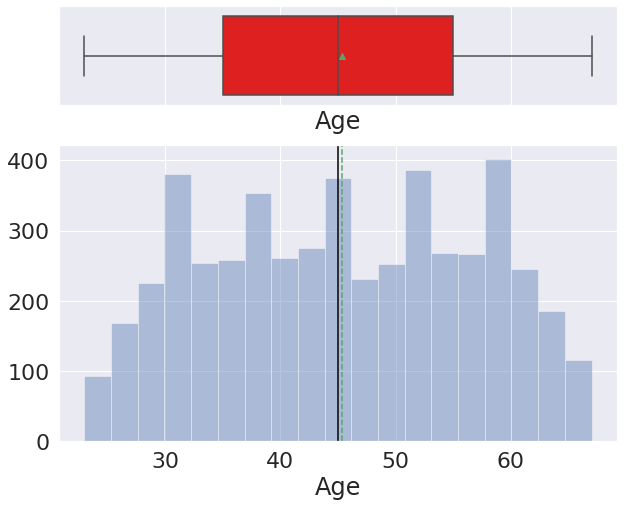

In [6]:
histogram_boxplot(df.Age);

In [7]:
df.Age.kurtosis()

-1.1530672623735783

In [8]:
df.Age.skew()

-0.02934068151284029

**Concept [Kurtosis and skewness]**: 
- If the kurtosis is less than zero, then the distribution is light tails and is called a platykurtic distribution. If the kurtosis is greater than zero, then the distribution has heavier tails and is called a leptokurtic distribution.

- The skewness for a normal distribution is zero, and any symmetric data should have a skewness near zero. Negative values for the skewness indicate data that are skewed left and positive values for the skewness indicate data that are skewed right.

**Remarks** 
- Age variable has a negative kurtosis and clearly flat top (and light tails) as shown in the plot above. This is a platykurtic distribution - from the concept of kurtosis.
- From the boxplot and the histogram with median and mean above, the Age data is not skewed. A skew value of -0.0293 (close to zero) is evidence to the said conclusion.
- The median and mean age is around 45 years.

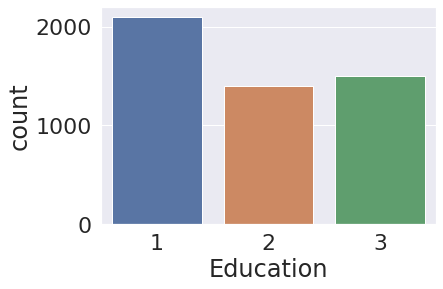

In [9]:
sns.countplot(df.Education);

In [10]:
df.Education.value_counts(normalize=True)

1    0.4192
3    0.3002
2    0.2806
Name: Education, dtype: float64

**Observation:** Majority (41.9%) of the customers in the dataset are undergraduate level, 28.1% are the graduates and 30.0% advanced level.

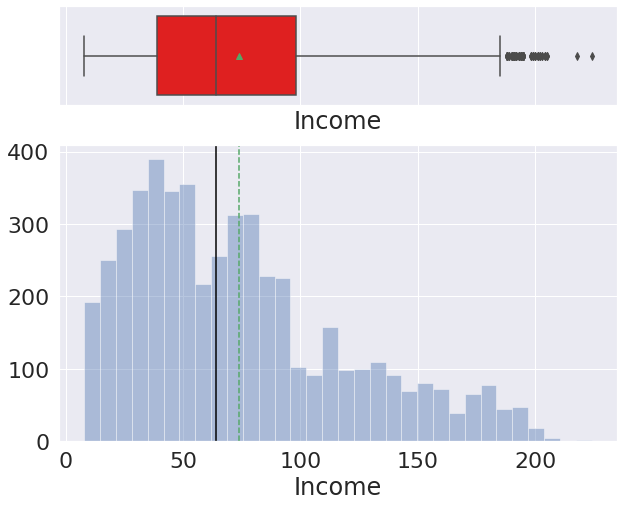

In [11]:
histogram_boxplot(df.Income)

In [12]:
df.Income.skew()

0.8413386072610816

**Observations:** 
- Income is skewed to the right - evidence from the histogram, skew value and the fact that median<mean.
- There are upper outliers but no lower outliers as shown in the boxplot.
- The mean income is around 75 thousand dollars per annum and the median is roughly 63 thousand dollars per annum.

In [13]:
len(df.ZIPCode.unique())

# There are 467 unique ZIP addresses - a high cardinality variable. For this reason, we hypothesize that this
# variable might not be significant when building the classification model.

467

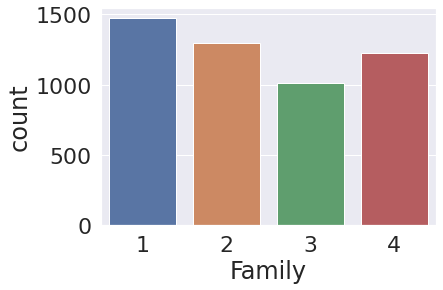

In [14]:
sns.countplot(df.Family);

In [15]:
df.Family.value_counts(normalize=True)*100

1    29.44
2    25.92
4    24.44
3    20.20
Name: Family, dtype: float64

**Observation** Majority of the customers (29.44%) have one child, followed by two-children families (25.92%), 4-children at 24.44% and lastly 3-children family at 20.2%. In general, the family sizes are spread equaly(roughly) from 1 to 4. 

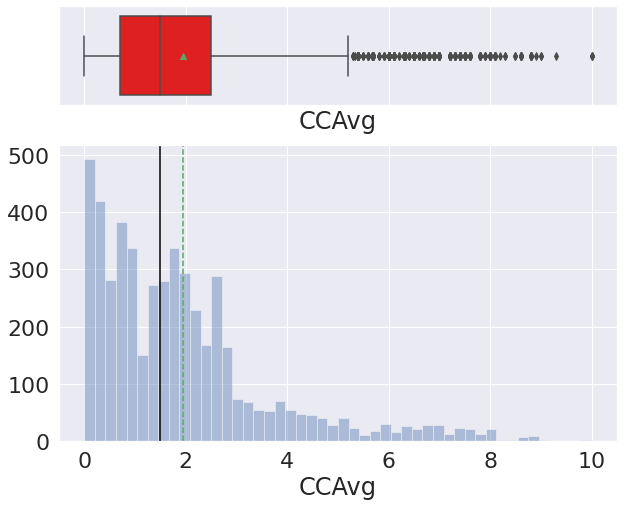

In [16]:
histogram_boxplot(df.CCAvg)

In [17]:
df.CCAvg.skew()

1.5984433366678663

**Observation**: 
- CCAvg - Avg. spending on credit cards per month (in thousand dollars)- is highly skewed to the right - evident by the skey value, the shape of the histogram and the fact that mean>medain.
- There are upper outliers and no lower outliers.

In [18]:
df.head()

,ID,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [19]:
# It might be interesting to know the number of people who took mortgage (of any value)
# and those who didn't
no_mor = len(df.Mortgage.loc[df.Mortgage==0])
mor = len(df) - no_mor
print("There are {}({}%) individuals who took no morgage.".format(no_mor,round(no_mor/len(df)*100,2)))
print("{}({}%) people took morgage(irrespective of the value of the mortgage).".format(mor, round(mor/len(df)*100,2)))

There are 3462(69.24%) individuals who took no morgage.
1538(30.76%) people took morgage(irrespective of the value of the mortgage).


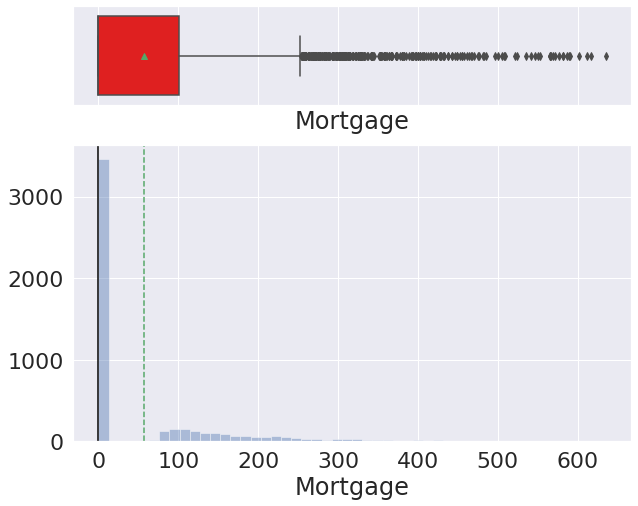

In [20]:
histogram_boxplot(df.Mortgage)

In [21]:
df.Mortgage.skew()

2.1040023191079444

**Observation(s)**:
- Majority of the individuals (69.24%) took no house morgage.
- Mortgage variable is highly skewed to the right with alot of outliers on the right. 

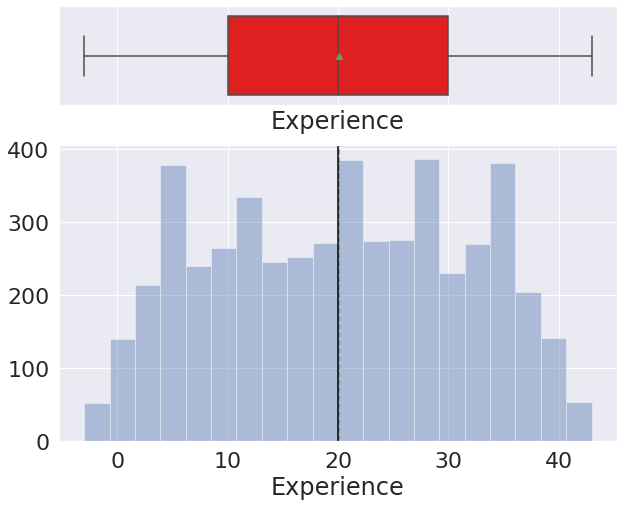

In [22]:
histogram_boxplot(df.Experience)

In [23]:
df.Experience.kurtosis() #platykurtic distribution

-1.12152278596998

In [24]:
df.Experience.skew() # Not skewed

-0.026324688402384513

**Observation**: 
- There are no outliers in the Experience variable. It is, however, surprising to find that there are data points with negative years of proffesional experince.
- By the kurtosis value and the plot of the histogram - the distriubution is platykurtic whereas when considering the skewness - the distribution is not skewed as shown in the histogram, the skew value and the fact that mean is approximately median. 

In [25]:
# Filtering the data points with negative Experince
neg_exp = df.loc[df.Experience<0]
neg_exp.head()

,ID,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
89,90,25,-1,113,94303,4,2.30,3,0,0,0,0,0,1
226,227,24,-1,39,94085,2,1.70,2,0,0,0,0,0,0
315,316,24,-2,51,90630,3,0.30,3,0,0,0,0,1,0
451,452,28,-2,48,94132,2,1.75,3,89,0,0,0,1,0
524,525,24,-1,75,93014,4,0.20,1,0,0,0,0,1,0


In [26]:
print("There are {} data points with negative Experience values.".format(len(neg_exp)))

#We will fix this one in the preprocessing stage

There are 52 data points with negative Experience values.


Personal_Loan
{0: 0.904, 1: 0.096}


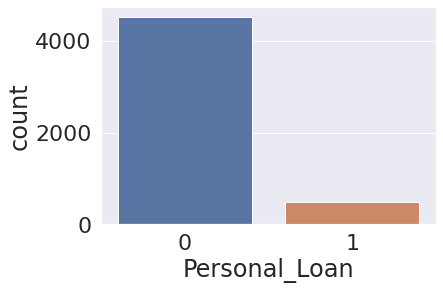

Securities_Account
{0: 0.8956, 1: 0.1044}


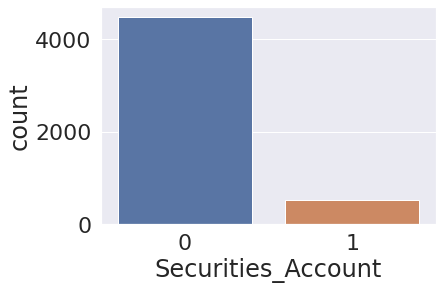

CD_Account
{0: 0.9396, 1: 0.0604}


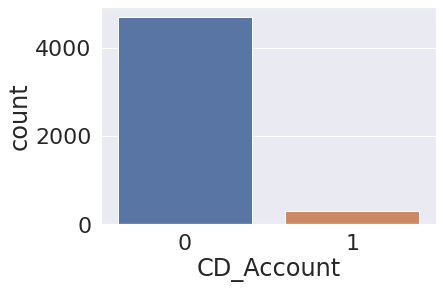

Online
{1: 0.5968, 0: 0.4032}


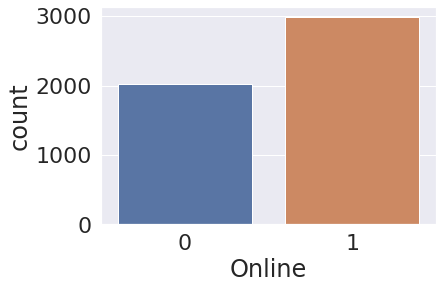

CreditCard
{0: 0.706, 1: 0.294}


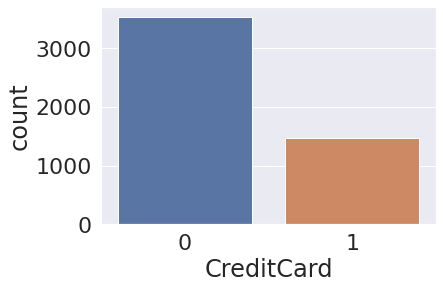

In [27]:
categorical_col = ["Personal_Loan", "Securities_Account", "CD_Account", "Online", "CreditCard"]

for col in categorical_col:
    print(col)
    print(dict(df[col].value_counts(normalize=True)))
    sns.countplot(df[col])
    plt.show()

 Observations:
 - 90.4% of the customers rescinded the personal loan offered in the last campaign. Given that this is the target variable, we can say that our data is highly imbalanced.
 - 89.56% have no Securities_Account,
 - Only 6.04% of the customers have Certificate of Deposit (CD_Account) with AllLife bank,
 - 59.68% of the customers uses internet banking facilities (Online),
 - 29.4% uses CreditCard provided by the bank.

## Bivariate Analysis

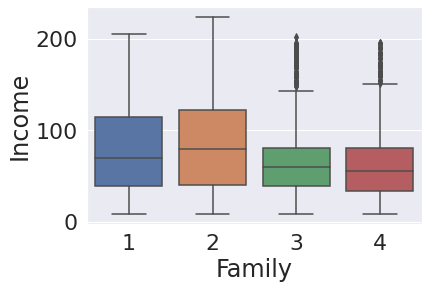

In [28]:
sns.boxplot(y="Income", x="Family", data=df);

In [29]:
pd.crosstab(df.Family,df.Securities_Account)

Securities_Account,0,1
Family,,
1,1330,142
2,1161,135
3,904,106
4,1083,139


In [30]:
df.columns

Index(['ID', 'Age', 'Experience', 'Income', 'ZIPCode', 'Family', 'CCAvg',
       'Education', 'Mortgage', 'Personal_Loan', 'Securities_Account',
       'CD_Account', 'Online', 'CreditCard'],
      dtype='object')

In [31]:
pd.crosstab(df.Education,df.Personal_Loan)

Personal_Loan,0,1
Education,,
1,2003,93
2,1221,182
3,1296,205


<AxesSubplot:xlabel='Family', ylabel='Experience'>

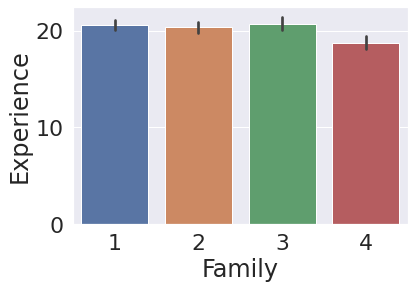

In [32]:
sns.barplot(df.Family, df.Experience)

In [33]:
#Based on the data description, we have the following as numeric and categorical variables
numeric_cols = ["Age", "Experience", "Income", "CCAvg", "Education", "Mortgage"]
categorical_cols = ["Securities_Account", "CD_Account", "Online", "CreditCard"]

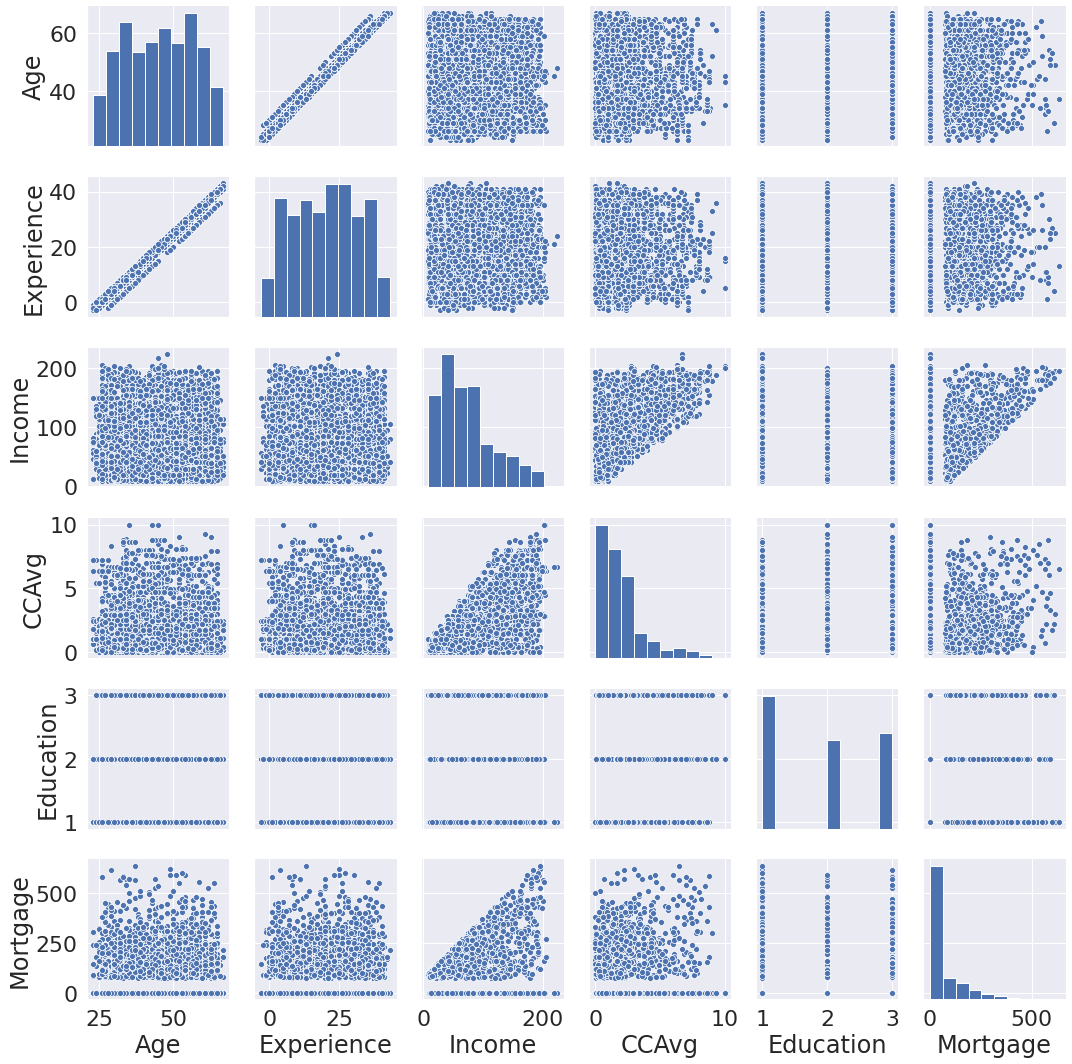

In [34]:
sns.pairplot(df[numeric_cols])

# DATA PREPROCESSING

## Identifying and treating outliers on numeric variables

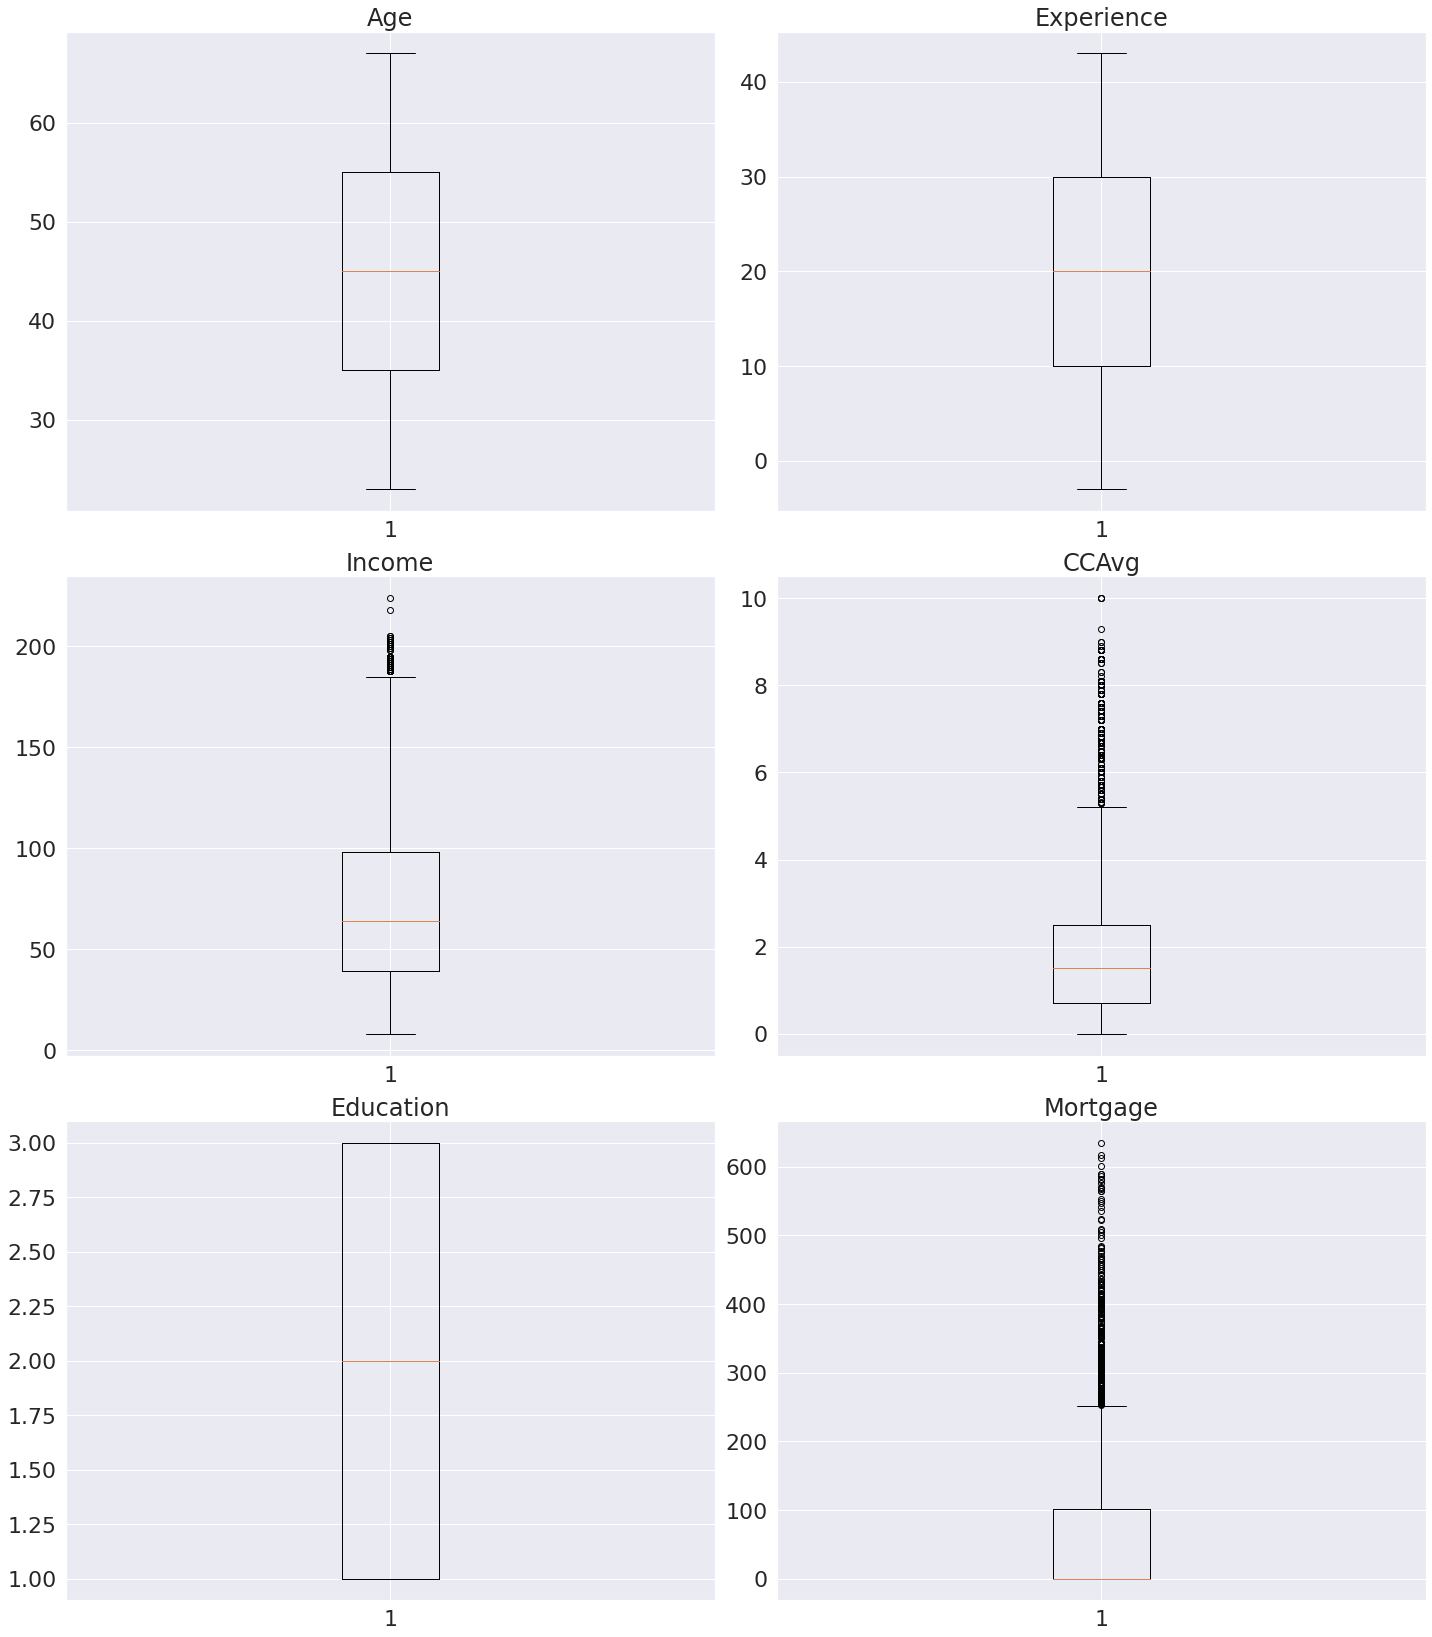

In [35]:
# outlier detection using boxplot
plt.figure(figsize=(20,30))
for i, variable in enumerate(numeric_cols):
    plt.subplot(4,2,i+1)
    plt.boxplot(df[variable],whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()

## Observations:
- The following variables have upper outliers: Income, CCAvg and Mortgage. We will treat those.
- Age, Experince and Education has no outliers
- There are no variables with lower outliers.

In [36]:
def treat_outliers(df,col):
    '''
    treats outliers in a varaible
    col: str, name of the numerical varaible
    df: data frame
    col: name of the column
    '''
    Q1=df[col].quantile(0.25) # 25th quantile
    Q3=df[col].quantile(0.75)  # 75th quantile
    IQR=Q3-Q1
    Lower_Whisker = Q1 - 1.5*IQR 
    Upper_Whisker = Q3 + 1.5*IQR
    df[col] = np.clip(df[col], Lower_Whisker, Upper_Whisker) # all the values samller than Lower_Whisker will be assigned value of Lower_whisker 
                                                            # and all the values above upper_whishker will be assigned value of upper_Whisker 
    return df
    

In [37]:
 col_list = ["Income", "CCAvg", "Mortgage"]

In [38]:
for c in col_list:
    df = treat_outliers(df,c)
        

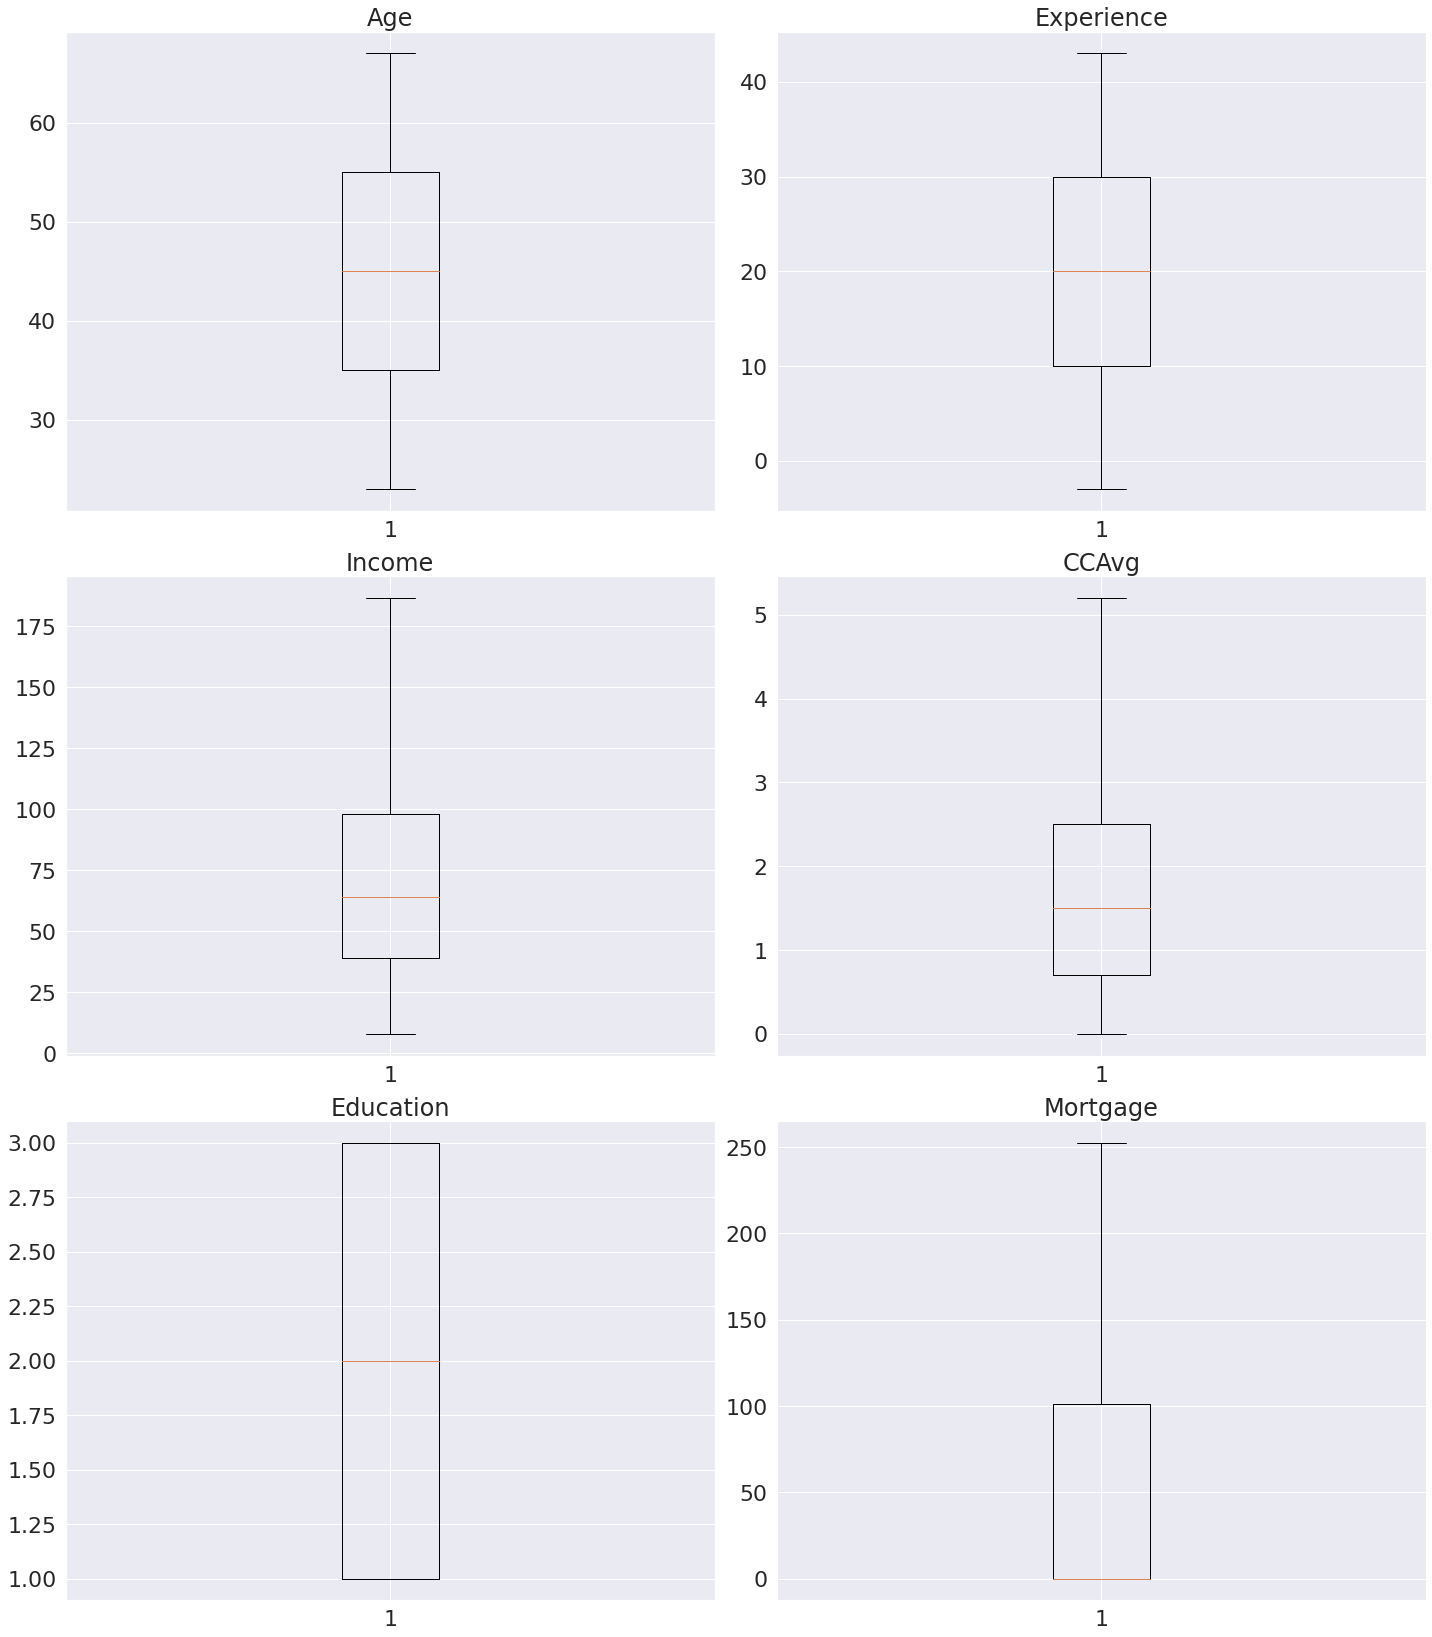

In [39]:
# Check that outliers has been treated boxplot
plt.figure(figsize=(20,30))
for i, variable in enumerate(numeric_cols):
    plt.subplot(4,2,i+1)
    plt.boxplot(df[variable],whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()

**Observation:** Outliers have been treated.

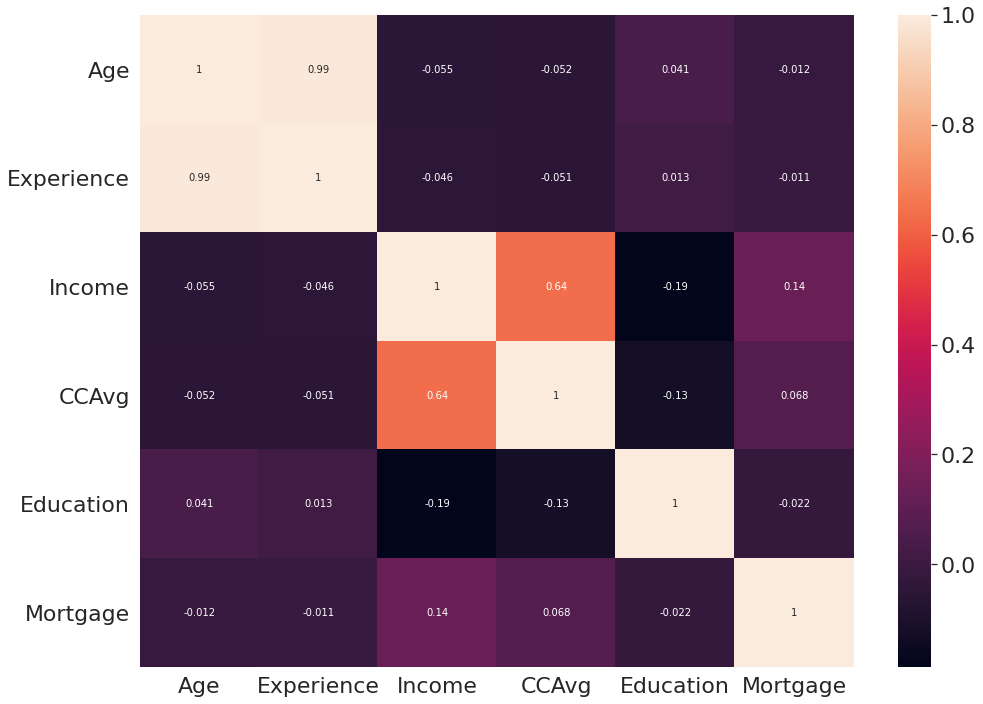

In [40]:
corr = df[numeric_cols].corr()

# plot the heatmap
plt.figure(figsize=(16,12))
sns.heatmap(corr, annot=True);

**Observations:** 

No variables were significantly correlated except Age vs Experience and Income vs CCAvg. 

The former has very strong positive correlation (almost perfect) with correlation value of 0.99 ad the latter has a fairly strong positive correlation with a value of 0.64.

In [41]:
# converting categorical varaible to category type
# categorical column should be converted to categorical type 
for colmn in categorical_cols:
    df[colmn] = df[colmn].astype('category')

In [42]:
df.dtypes

ID                       int64
Age                      int64
Experience               int64
Income                 float64
ZIPCode                  int64
Family                   int64
CCAvg                  float64
Education                int64
Mortgage               float64
Personal_Loan            int64
Securities_Account    category
CD_Account            category
Online                category
CreditCard            category
dtype: object

# MODEL BUILDING

In [43]:
## Defining X and Y variables
X = df.drop(['Personal_Loan',"ID","ZIPCode"], axis=1)
Y = df[['Personal_Loan']].astype("int")

#Convert categorical variables to dummy variables
X = pd.get_dummies(X, drop_first=True)

#Splitting the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=24)

### Check for Multicollinearity

* There are different ways of detecting(or  testing) multi-collinearity, one such way is Variation Inflation Factor.

* **Variance  Inflation  factor**:  Variance  inflation  factors  measure  the  inflation  in  the variances of the regression coefficients estimates due to collinearities that exist among the  predictors.  It  is  a  measure  of  how  much  the  variance  of  the  estimated  regression coefficient βk is “inflated”by  the  existence  of  correlation  among  the  predictor variables in the model. 

* General Rule of thumb: If VIF is 1 then there is no correlation among the kth predictor and the remaining predictor variables, and  hence  the variance of β̂k is not inflated at all. Whereas if VIF exceeds 5, we say there is moderate VIF and if it is 10 or exceeding 10, it shows signs of high multi-collinearity. But the purpose of the analysis should dictate which threshold to use. 

In [44]:
# dataframe with numerical column only
num_feature_set = X.copy()
from statsmodels.tools.tools import add_constant
num_feature_set = add_constant(num_feature_set)

In [45]:
vif_series1 = pd.Series([variance_inflation_factor(num_feature_set.values,i) for i in range(num_feature_set.shape[1])],index=num_feature_set.columns)
print('Series before feature selection: \n\n{}\n'.format(vif_series1))

Series before feature selection: 

const                   453.411518
Age                      93.702193
Experience               93.605931
Income                    1.801472
Family                    1.033915
CCAvg                     1.699337
Education                 1.114187
Mortgage                  1.022982
Securities_Account_1      1.137044
CD_Account_1              1.329208
Online_1                  1.039575
CreditCard_1              1.107616
dtype: float64



**Remark:**
- Two variables namely: Age and Experience have a strong multicollinerity. We will drop one. We proceed by dropping Experience.

In [46]:
## Defining X and Y variables - considering that we will drop Experince
X = df.drop(['Personal_Loan',"ID","ZIPCode","Experience"], axis=1)
Y = df[['Personal_Loan']].astype("int")

#Convert categorical variables to dummy variables
X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=24)

{0: 0.904, 1: 0.096}


<AxesSubplot:xlabel='Personal_Loan', ylabel='count'>

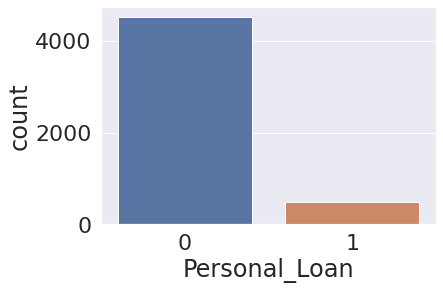

In [47]:
# A recap
print(dict(Y["Personal_Loan"].value_counts(normalize=True)))
sns.countplot(Y["Personal_Loan"])

**Recap:**

Our data is highly imbalanced. Considering Personal_Loan, which is the target variable, 90.4% of the people on the dataset did not take personal loan whereas only 9.6% did. 

Given this fact, we will consider evaluation metrics beyond accuracy score. We will look at other metrics like: precision, recall, f1 and AUC-ROC.

## Logistic Regression Classifier

In [48]:
logistic = LogisticRegression(solver='newton-cg',max_iter=1000,penalty='l2',verbose=True,n_jobs=-1,random_state=0)

# There are several optimizer, we are using optimizer called as 'newton-cg' with max_iter equal to 10000 
# max_iter indicates number of iteration needed to converge

logistic.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


LogisticRegression(max_iter=1000, n_jobs=-1, random_state=0, solver='newton-cg',
                   verbose=True)

In [49]:
#Predict for train set
pred_train = logistic.predict(X_train)
pred_test = logistic.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
#mat_train = confusion_matrix(y_train,pred_train)

In [50]:
def ConfusionMatrix(y_actual, pred, set1, save_as=None):
    plt.figure(figsize=(10,8))
    
    cm = confusion_matrix(y_actual,pred, labels=[1, 0])

    df_cm = pd.DataFrame(cm, index=["Yes","No"], columns=["Yes","No"])

    percent = [np.round(i/np.sum(cm.flatten())*100,2) for i in cm.flatten()]
    
    values = cm.flatten()
    labels = ["{}\n({}%)".format(i,j) for i, j in
                  zip(values,percent)]
    labels = np.array(labels).reshape(2,2)
    
    sns.heatmap(df_cm, annot= labels, fmt= "")
    
    plt.title("Confusion Matrix for {} set.".format(set1))
    plt.xlabel("Predicted Values")
    plt.ylabel("True Values")
    
    if save_as != None:
        plt.savefig("./images/{}".format(save_as))
    
    plt.show()
    
    print(set1,cm)
    
    return None


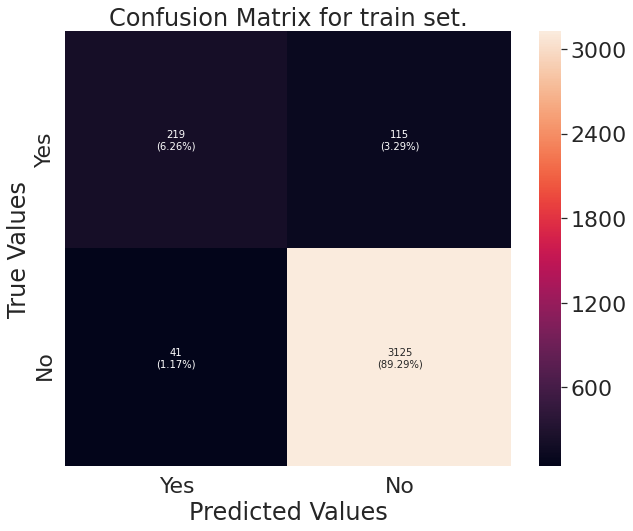

train [[ 219  115]
 [  41 3125]]


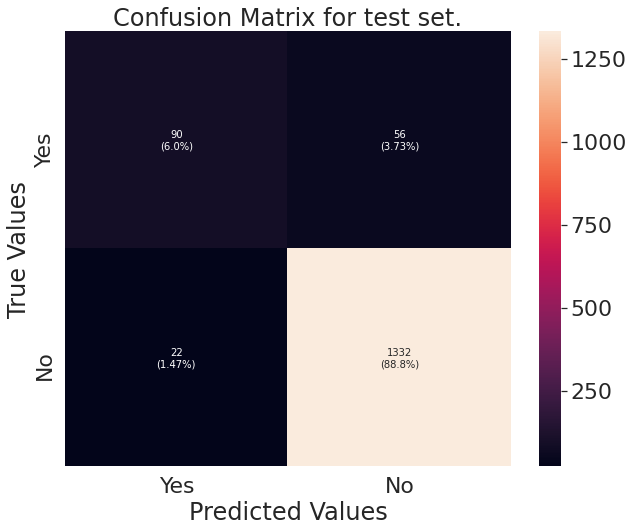

test [[  90   56]
 [  22 1332]]


In [51]:
# let us make confusion matrix on train set
ConfusionMatrix(y_train,pred_train, set1="train", save_as="train_confusion_matrix_thresh05.png")

# let us make confusion matrix on train set
ConfusionMatrix(y_test,pred_test, set1="test", save_as="test_confusion_matrix_thresh05.png")

**Observations:**

(Consider "No" and 0 as Negative, "Yes" and 1 as Positive)

- For the train set: there are 89.3% True Negatives, 6.23% True Positives, 1.11% False Positives and 3.31% False Negatives. These values are calculated out of total data points on the train set.

- For the test set: there are 88.8% True Negatives, 5.93% True Positives, 1.47% False Positives and 3.8% False Negatives. Again, these values are calculated out of total data points on the test set.

In [52]:
# Accuracy with a threhold of 0.5
from sklearn.metrics import accuracy_score
print('Accuracy on train data:',accuracy_score(y_train, pred_train))
print('Accuracy on test data:',accuracy_score(y_test, pred_test))

Accuracy on train data: 0.9554285714285714
Accuracy on test data: 0.948


**Observations and remarks:**
- Accuracy = (tp+tn)/(tp+tn+fp+fn) = (tp+tn)/observations_count
- For train set, the model attains 95.5% accuracy and for test set, the model attains accuracy of 94.8%.
- Given that the dataset is imbalanced, accuracy may be a biased metric. Accuracy metric will be affected by the dominant class. Class 0/"No" is the dominant class. It makes approximately 90% of the data points.

In [53]:
print("Precision, recall and f1 scores for the model on train data.")
print("Precision: ",precision_score(y_train, pred_train))
print("Recall: ",recall_score(y_train, pred_train))
print("F1 score: ",f1_score(y_train, pred_train))

Precision, recall and f1 scores for the model on train data.
Precision:  0.8423076923076923
Recall:  0.655688622754491
F1 score:  0.7373737373737373


In [54]:
print("Precision, recall and f1 scores for the model on test data.")
print("Precision: ",precision_score(y_test, pred_test))
print("Recall: ",recall_score(y_test, pred_test))
print("F1 score: ",f1_score(y_test, pred_test))

Precision, recall and f1 scores for the model on test data.
Precision:  0.8035714285714286
Recall:  0.6164383561643836
F1 score:  0.6976744186046512


**Observations and remarks:**
- To sort out the bootleneck of using accuracy as a metric mentioned above, we will consider precision, recall and f1.
- Precision is defined as the fraction of relevant instances among all retrieved instances. Recall, also referred to as ‘sensitivity, is the fraction of retrieved instances among all relevant instances. A perfect classifier has precision and recall both equal to 1.

- Precision = tp/(tp+fp) and Recall = tp/(tp+fn)

- The model attains a precision score of 84.23% on the training data and 80.35% on the test data. Recall scores are 65.57% and 61.64% for training and testing set, respectively.

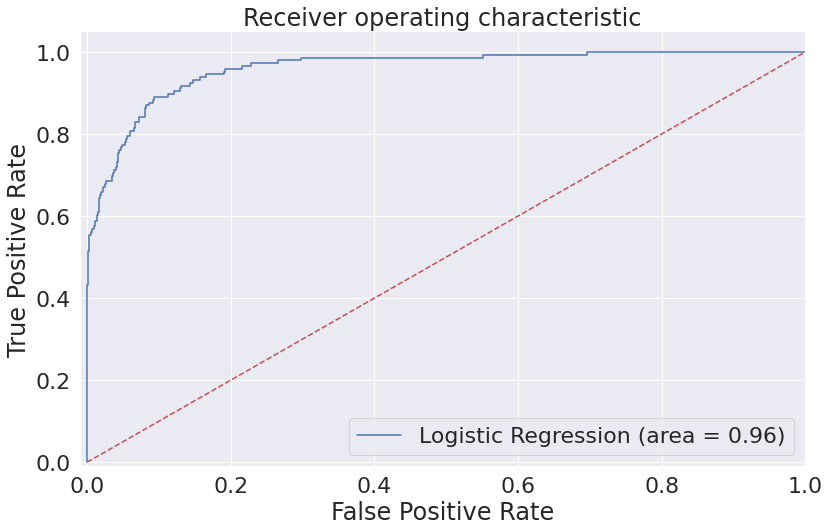

In [55]:
#AUC ROC curve
logit_roc_auc = roc_auc_score(y_test, logistic.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, logistic.predict_proba(X_test)[:,1])
plt.figure(figsize=(13,8))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('./images/ROC.png')
plt.show()

In [56]:
# The optimal cut off would be where tpr is high and fpr is low where:
# tpr - True Positive Rate
# fpr - False Positive Rate
fpr, tpr, thresholds = roc_curve(y_test, logistic.predict_proba(X_test)[:,1])

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(optimal_threshold)

0.12433566184358151


In [57]:
target_names = ['No', 'Yes']
y_pred_train = (logistic.predict_proba(X_train)[:,1]>optimal_threshold).astype(int)
y_pred_test = (logistic.predict_proba(X_test)[:,1]>optimal_threshold).astype(int)

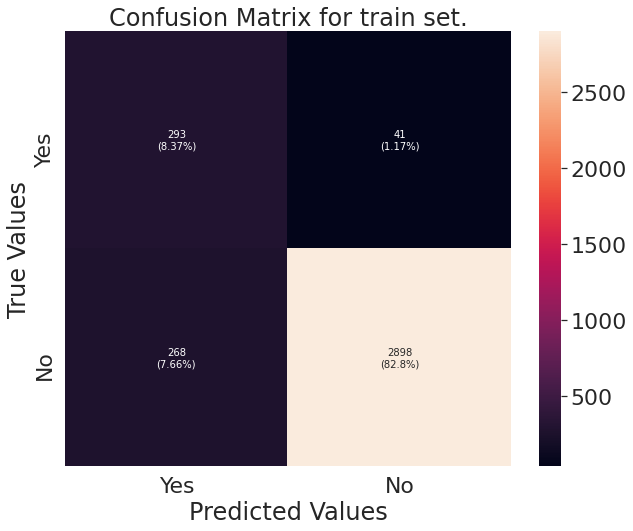

train [[ 293   41]
 [ 268 2898]]


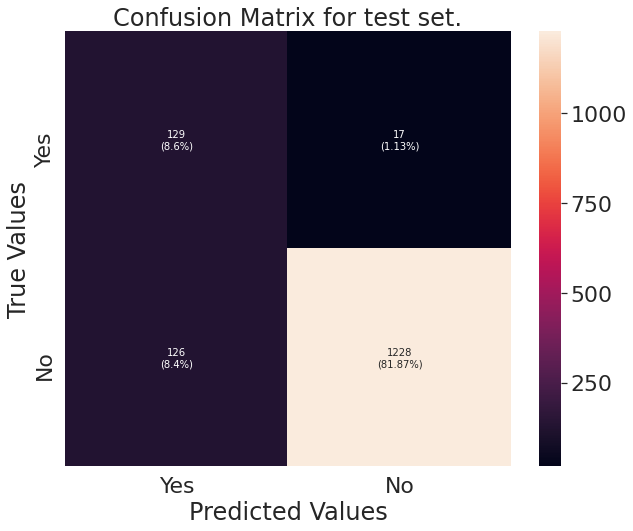

test [[ 129   17]
 [ 126 1228]]


In [58]:
ConfusionMatrix(y_train,y_pred_train, set1="train", save_as="trainConfusionMatrix_optimal.png")
ConfusionMatrix(y_test,y_pred_test, set1="test", save_as="testConfusionMatrix_optimal.png")

In [59]:
#Accuracy with optimal threhold
from sklearn.metrics import accuracy_score
print('Accuracy on train data:',accuracy_score(y_train, y_pred_train) )
print('Accuracy on test data:',accuracy_score(y_test, y_pred_test))


Accuracy on train data: 0.9117142857142857
Accuracy on test data: 0.9046666666666666


In [60]:
print("Precision, recall and f1 scores for the model on train data.")
print("Precision: ",precision_score(y_train, y_pred_train))
print("Recall: ",recall_score(y_train, y_pred_train))
print("F1 score: ",f1_score(y_train, y_pred_train))

Precision, recall and f1 scores for the model on train data.
Precision:  0.5222816399286988
Recall:  0.8772455089820359
F1 score:  0.6547486033519553


In [61]:
print("Precision, recall and f1 scores for the model on train data.")
print("Precision: ",precision_score(y_test, y_pred_test))
print("Recall: ",recall_score(y_test, y_pred_test))
print("F1 score: ",f1_score(y_test, y_pred_test))

Precision, recall and f1 scores for the model on train data.
Precision:  0.5058823529411764
Recall:  0.8835616438356164
F1 score:  0.6433915211970074


**Observation:**

- By default the model is evaluated at a threshold of 0.5. A different threshold exits where tpr - True Positive Rate is highest and fpr - False Positive Rate is lowest. This threshold is called an optimal threshold. The optimal threshold is established to be at 0.124. This value means that a probability >= 0.124 is considered a positive instance and a probability less than 0.124 is considered a negative instance.

- Considering the optimal threshold, False Negatives dropped from 3.73% to 1.13% for the  test set. True positives increased from 6.0% to 8.6%.

## Decision Tree (DT)

In [62]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

### DT with default params

In [63]:
dTree = DecisionTreeClassifier(criterion = 'gini', random_state=1)
dTree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [64]:
print("Accuracy on training set : ",dTree.score(X_train, y_train))
print("Accuracy on test set : ",dTree.score(X_test, y_test))

Accuracy on training set :  1.0
Accuracy on test set :  0.982


In [65]:
pred_train_dt = dTree.predict(X_train)
pred_test_dt = dTree.predict(X_test)

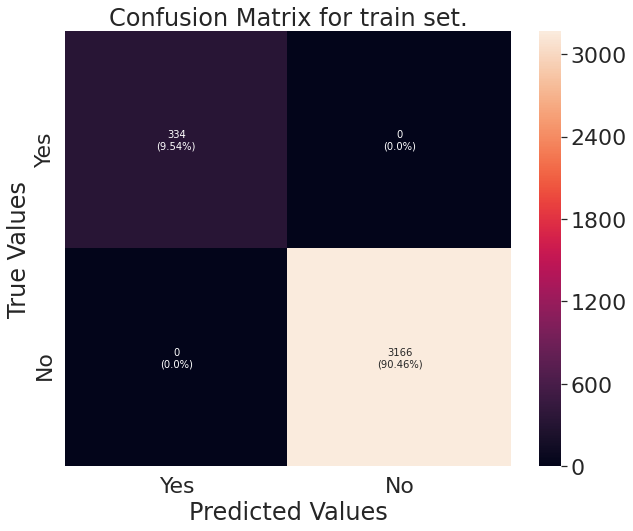

train [[ 334    0]
 [   0 3166]]


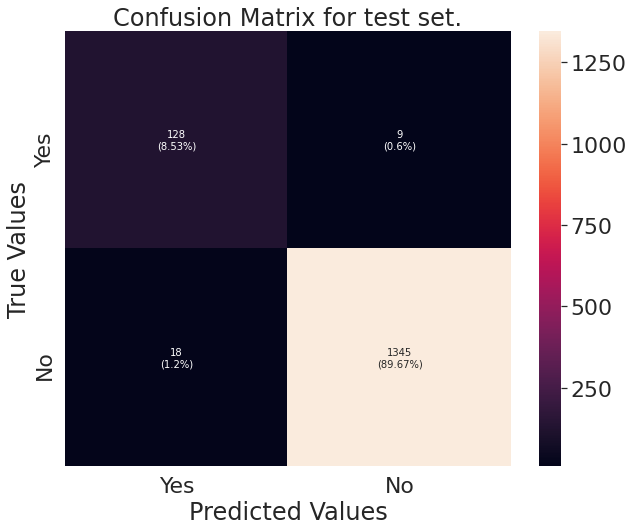

test [[ 128    9]
 [  18 1345]]


In [66]:
ConfusionMatrix(pred_train_dt ,y_train,set1="train")
ConfusionMatrix(pred_test_dt,y_test,set1="test")

In [67]:
print("Perfomance metrics for Decision Tree (default params) on train set")
print("Precision score for train set",precision_score(pred_train_dt,y_train))
print("Recall score for train set",recall_score(pred_train_dt,y_train))
print("F1 score for train set",f1_score(pred_train_dt,y_train))

Perfomance metrics for Decision Tree (default params) on train set
Precision score for train set 1.0
Recall score for train set 1.0
F1 score for train set 1.0


In [68]:
print("Perfomance metrics for Decision Tree (default params)on test set")
print("Precision score for test set",precision_score(pred_test_dt,y_test))
print("Recall score for test set",recall_score(pred_test_dt,y_test))
print("F1 score for test set",f1_score(pred_test_dt,y_test))

Perfomance metrics for Decision Tree (default params)on test set
Precision score for test set 0.8767123287671232
Recall score for test set 0.9343065693430657
F1 score for test set 0.9045936395759717


### Visualizing the Decision Tree

In [69]:
feature_names = list(X.columns)
print(feature_names)

['Age', 'Income', 'Family', 'CCAvg', 'Education', 'Mortgage', 'Securities_Account_1', 'CD_Account_1', 'Online_1', 'CreditCard_1']


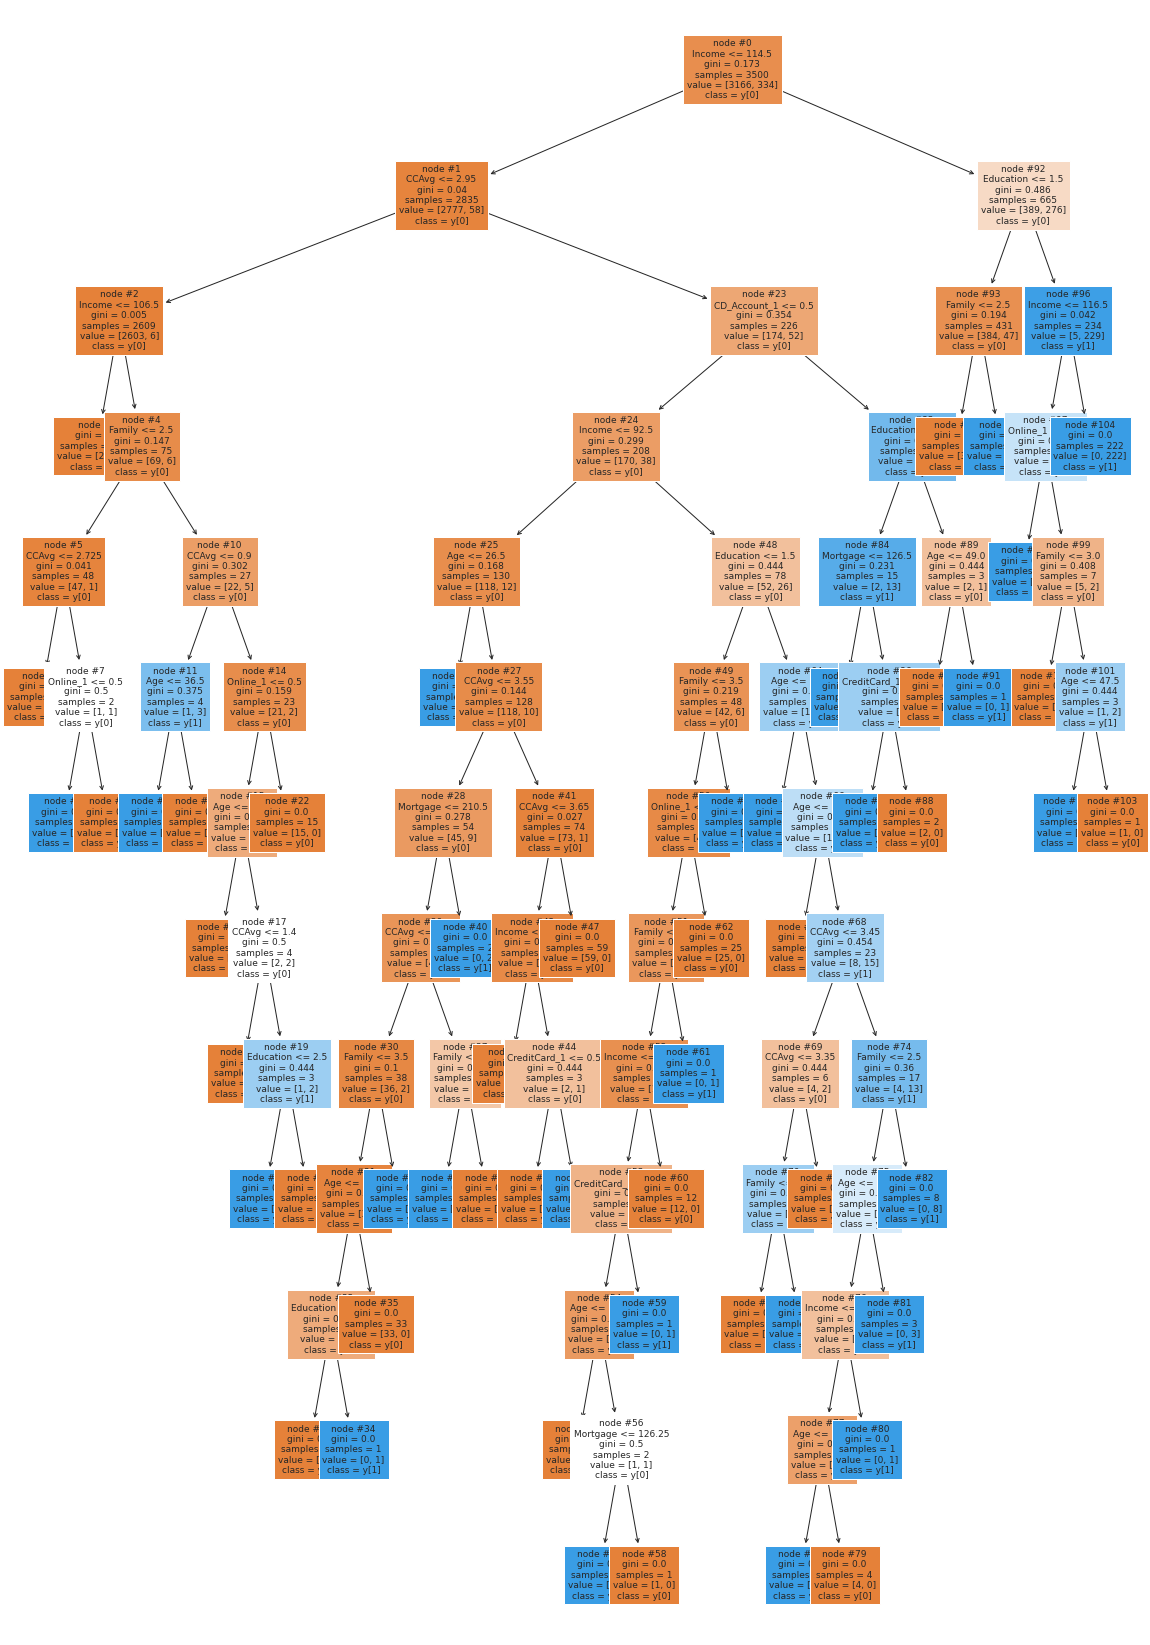

In [70]:
plt.figure(figsize=(20,30))
tree.plot_tree(dTree,feature_names=feature_names,filled=True,fontsize=9,node_ids=True,class_names=True)
plt.show()

In [71]:
# Text report showing the rules of a decision tree -

print(tree.export_text(dTree,feature_names=feature_names,show_weights=True))

|--- Income <= 114.50
|   |--- CCAvg <= 2.95
|   |   |--- Income <= 106.50
|   |   |   |--- weights: [2534.00, 0.00] class: 0
|   |   |--- Income >  106.50
|   |   |   |--- Family <= 2.50
|   |   |   |   |--- CCAvg <= 2.73
|   |   |   |   |   |--- weights: [46.00, 0.00] class: 0
|   |   |   |   |--- CCAvg >  2.73
|   |   |   |   |   |--- Online_1 <= 0.50
|   |   |   |   |   |   |--- weights: [0.00, 1.00] class: 1
|   |   |   |   |   |--- Online_1 >  0.50
|   |   |   |   |   |   |--- weights: [1.00, 0.00] class: 0
|   |   |   |--- Family >  2.50
|   |   |   |   |--- CCAvg <= 0.90
|   |   |   |   |   |--- Age <= 36.50
|   |   |   |   |   |   |--- weights: [0.00, 3.00] class: 1
|   |   |   |   |   |--- Age >  36.50
|   |   |   |   |   |   |--- weights: [1.00, 0.00] class: 0
|   |   |   |   |--- CCAvg >  0.90
|   |   |   |   |   |--- Online_1 <= 0.50
|   |   |   |   |   |   |--- Age <= 33.50
|   |   |   |   |   |   |   |--- weights: [4.00, 0.00] class: 0
|   |   |   |   |   |   |--- Age > 

In [72]:
# importance of features in the tree building ( The importance of a feature is computed as the 
#(normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance )

print (pd.DataFrame(dTree.feature_importances_, columns = ["Importance"], index = X_train.columns).sort_values(by = 'Importance', ascending = False))

                      Importance
Education               0.404553
Income                  0.298879
Family                  0.171958
CCAvg                   0.054044
Age                     0.026318
CD_Account_1            0.019418
CreditCard_1            0.008590
Online_1                0.008487
Mortgage                0.007753
Securities_Account_1    0.000000


### DT model with depth restricted

In [73]:
dTree1 = DecisionTreeClassifier(criterion = 'gini',max_depth=3,random_state=1)
dTree1.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=1)

In [74]:
pred_train_dt1 = dTree1.predict(X_train)
pred_test_dt1 = dTree1.predict(X_test)

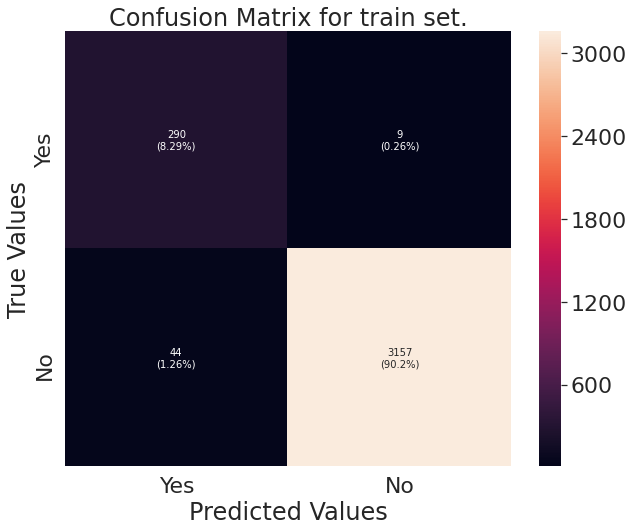

train [[ 290    9]
 [  44 3157]]


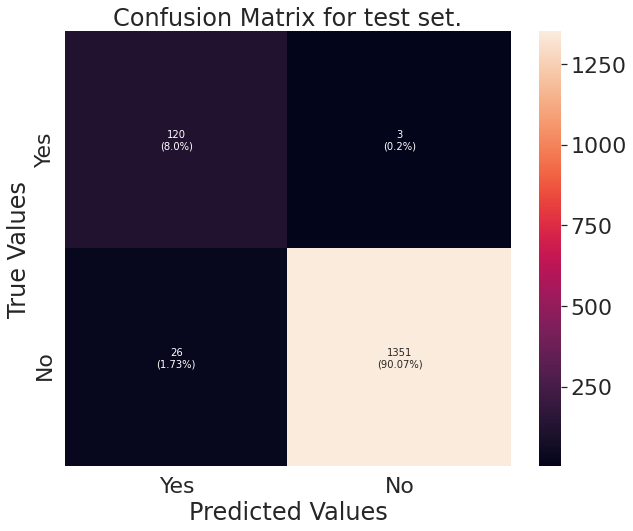

test [[ 120    3]
 [  26 1351]]


In [75]:
ConfusionMatrix(pred_train_dt1, y_train, set1="train")
ConfusionMatrix(pred_test_dt1, y_test, set1="test")

In [76]:
print("Perfomance metrics for Decision Tree (depth restricted) on train set")
print("Precision score for train set",precision_score(pred_train_dt1,y_train))
print("Recall score for train set",recall_score(pred_train_dt1,y_train))
print("F1 score for train set",f1_score(pred_train_dt1,y_train))

Perfomance metrics for Decision Tree (depth restricted) on train set
Precision score for train set 0.8682634730538922
Recall score for train set 0.9698996655518395
F1 score for train set 0.9162717219589258


In [77]:
print("Perfomance metrics for Decision Tree (depth restricted) on test set")
print("Precision score for test set",precision_score(pred_test_dt1,y_test))
print("Recall score for test set",recall_score(pred_test_dt1,y_test))
print("F1 score for test set",f1_score(pred_test_dt1,y_test))

Perfomance metrics for Decision Tree (depth restricted) on test set
Precision score for test set 0.821917808219178
Recall score for test set 0.975609756097561
F1 score for test set 0.8921933085501859


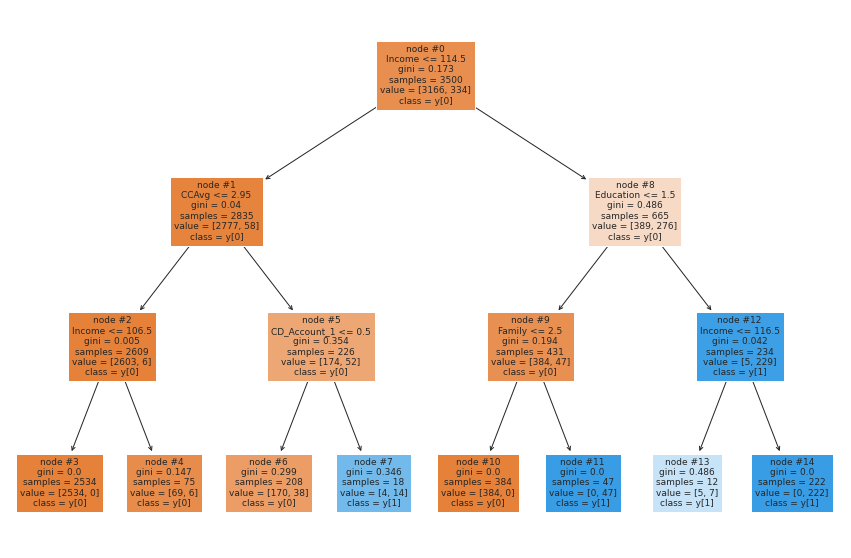

In [78]:
plt.figure(figsize=(15,10))

tree.plot_tree(dTree1,feature_names=feature_names,filled=True,fontsize=9,node_ids=True,class_names=True)
plt.show()

In [79]:
# Text report showing the rules of a decision tree -

print(tree.export_text(dTree1,feature_names=feature_names,show_weights=True))

|--- Income <= 114.50
|   |--- CCAvg <= 2.95
|   |   |--- Income <= 106.50
|   |   |   |--- weights: [2534.00, 0.00] class: 0
|   |   |--- Income >  106.50
|   |   |   |--- weights: [69.00, 6.00] class: 0
|   |--- CCAvg >  2.95
|   |   |--- CD_Account_1 <= 0.50
|   |   |   |--- weights: [170.00, 38.00] class: 0
|   |   |--- CD_Account_1 >  0.50
|   |   |   |--- weights: [4.00, 14.00] class: 1
|--- Income >  114.50
|   |--- Education <= 1.50
|   |   |--- Family <= 2.50
|   |   |   |--- weights: [384.00, 0.00] class: 0
|   |   |--- Family >  2.50
|   |   |   |--- weights: [0.00, 47.00] class: 1
|   |--- Education >  1.50
|   |   |--- Income <= 116.50
|   |   |   |--- weights: [5.00, 7.00] class: 1
|   |   |--- Income >  116.50
|   |   |   |--- weights: [0.00, 222.00] class: 1



In [80]:
# importance of features in the tree building ( The importance of a feature is computed as the 
#(normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance )

print (pd.DataFrame(dTree1.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values(by = 'Imp', ascending = False))

                           Imp
Education             0.441897
Income                0.332560
Family                0.161354
CCAvg                 0.041583
CD_Account_1          0.022605
Age                   0.000000
Mortgage              0.000000
Securities_Account_1  0.000000
Online_1              0.000000
CreditCard_1          0.000000


### Searching for the best hyperparameter values using Grid Search

In [81]:
from sklearn.model_selection import GridSearchCV

In [82]:
# Choose the type of classifier. 
grid_model = DecisionTreeClassifier(random_state=1)

# Grid of parameters to choose from
## add from article
parameters = {'max_depth': np.arange(1,10), 
              'min_samples_leaf': [1, 2, 5, 7, 10,15,20],
              'max_leaf_nodes' : [2, 3, 5, 10],
              'min_impurity_decrease': [0.001,0.01,0.1]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(grid_model, parameters, scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
grid_model = grid_obj.best_estimator_
print(grid_model.get_params())
# Fit the best algorithm to the data. 
grid_model.fit(X_train, y_train)

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 6, 'max_features': None, 'max_leaf_nodes': 10, 'min_impurity_decrease': 0.001, 'min_impurity_split': None, 'min_samples_leaf': 10, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 1, 'splitter': 'best'}


DecisionTreeClassifier(max_depth=6, max_leaf_nodes=10,
                       min_impurity_decrease=0.001, min_samples_leaf=10,
                       random_state=1)

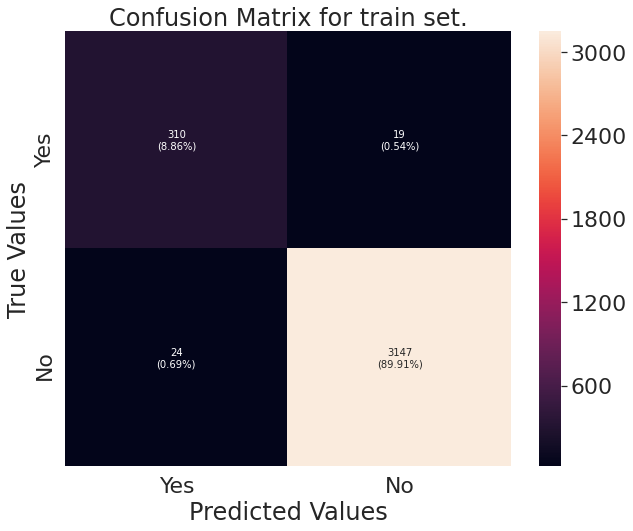

train [[ 310   19]
 [  24 3147]]


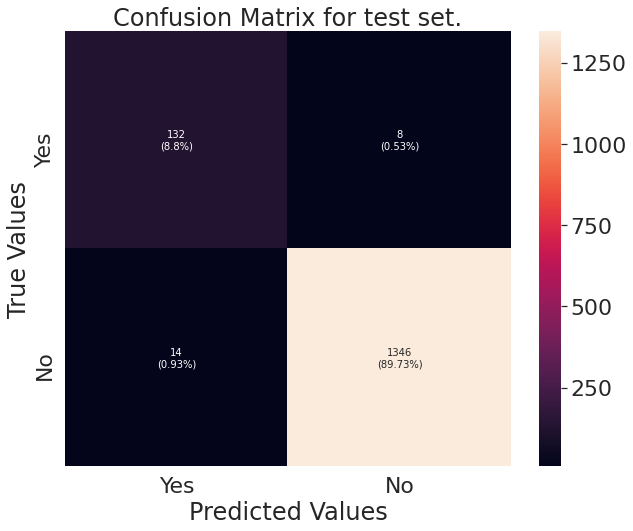

test [[ 132    8]
 [  14 1346]]


In [83]:
ConfusionMatrix(grid_model.predict(X_train),y_train,set1="train")
ConfusionMatrix(grid_model.predict(X_test),y_test,set1="test")

In [84]:
pred_train_dt2 = grid_model.predict(X_train)
pred_test_dt2 = grid_model.predict(X_test)

In [85]:
print("Perfomance metrics for Decision Tree (Grid Search) on train set")
print("Precision score for train set",precision_score(pred_train_dt2,y_train))
print("Recall score for train set",recall_score(pred_train_dt2,y_train))
print("F1 score for train set",f1_score(pred_train_dt2,y_train))

Perfomance metrics for Decision Tree (Grid Search) on train set
Precision score for train set 0.9281437125748503
Recall score for train set 0.9422492401215805
F1 score for train set 0.9351432880844645


In [86]:
print("Perfomance metrics for Decision Tree (Grid Search) on test set")
print("Precision score for test set",precision_score(pred_test_dt2,y_test))
print("Recall score for test set",recall_score(pred_test_dt2,y_test))
print("F1 score for test set",f1_score(pred_test_dt2,y_test))

Perfomance metrics for Decision Tree (Grid Search) on test set
Precision score for test set 0.9041095890410958
Recall score for test set 0.9428571428571428
F1 score for test set 0.923076923076923


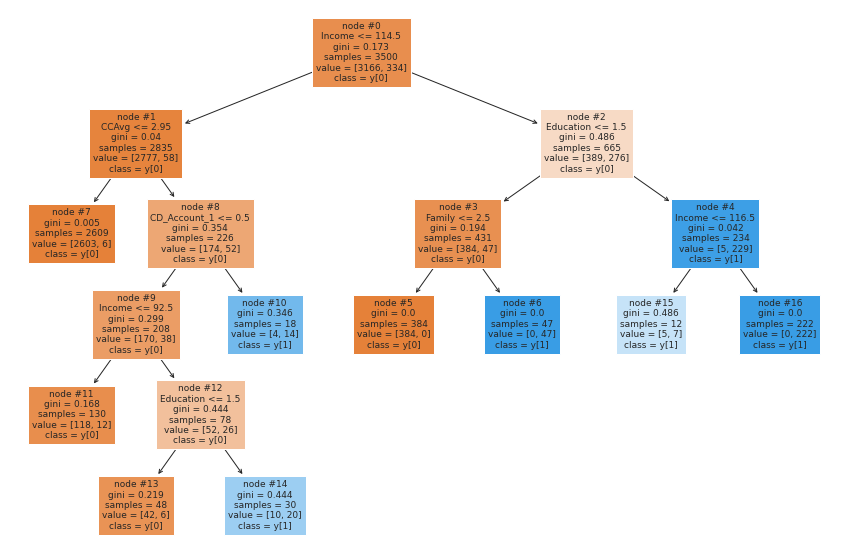

In [87]:
plt.figure(figsize=(15,10))

tree.plot_tree(grid_model,feature_names=feature_names,filled=True,fontsize=9,node_ids=True,class_names=True)
plt.show()

In [88]:
# importance of features in the tree building ( The importance of a feature is computed as the 
#(normalized) total reduction of the 'criterion' brought by that feature. It is also known as the Gini importance )

print (pd.DataFrame(grid_model.feature_importances_, columns = ["Importance"], index = X_train.columns).sort_values(by = 'Importance', ascending = False))

#Here we will see that importance of features has increased

                      Importance
Education               0.449295
Income                  0.331729
Family                  0.156656
CCAvg                   0.040373
CD_Account_1            0.021947
Age                     0.000000
Mortgage                0.000000
Securities_Account_1    0.000000
Online_1                0.000000
CreditCard_1            0.000000


### Pruning Decision Tree

In [89]:
clf = DecisionTreeClassifier(random_state=1)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

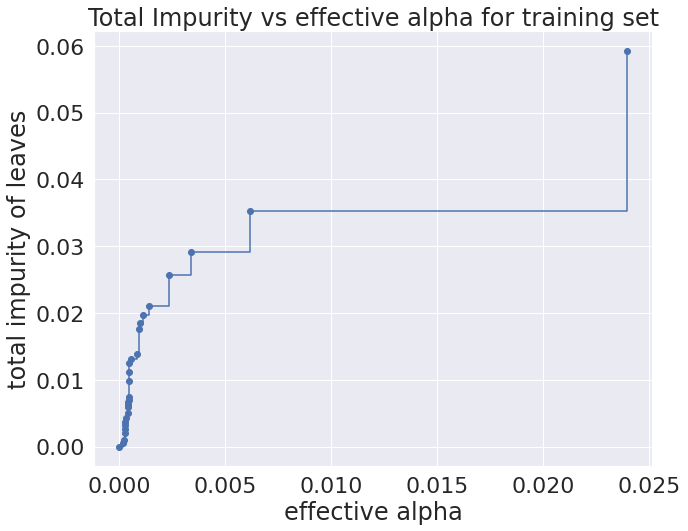

In [90]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

In [91]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=1, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.056727308826521716


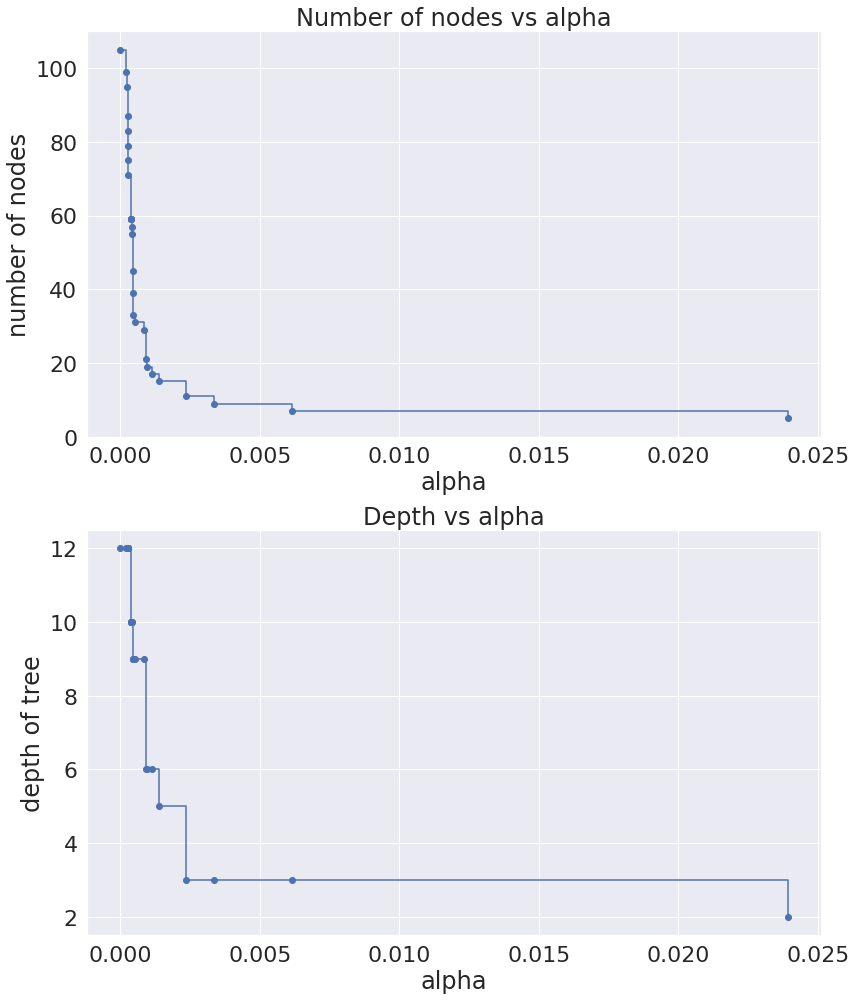

In [92]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1,figsize=(12,14))
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

In [93]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

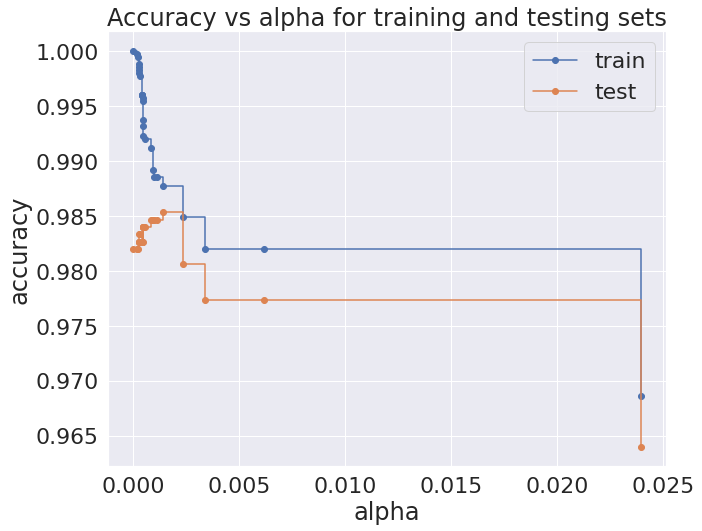

In [94]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [95]:
index_best_model = np.argmax(test_scores)
pruned_model = clfs[index_best_model]
print(pruned_model)
print('Training accuracy of pruned model: ',pruned_model.score(X_train, y_train))
print('Test accuracy of pruned model: ',pruned_model.score(X_test, y_test))

DecisionTreeClassifier(ccp_alpha=0.0013999999999999996, random_state=1)
Training accuracy of pruned model:  0.9877142857142858
Test accuracy of pruned model:  0.9853333333333333


In [96]:
recall_train=[]
for clf in clfs:
    pred_train3=clf.predict(X_train)
    values_train=metrics.recall_score(y_train,pred_train3)
    recall_train.append(values_train)

In [97]:
recall_test=[]
for clf in clfs:
    pred_test3=clf.predict(X_test)
    values_test=metrics.recall_score(y_test,pred_test3)
    recall_test.append(values_test)

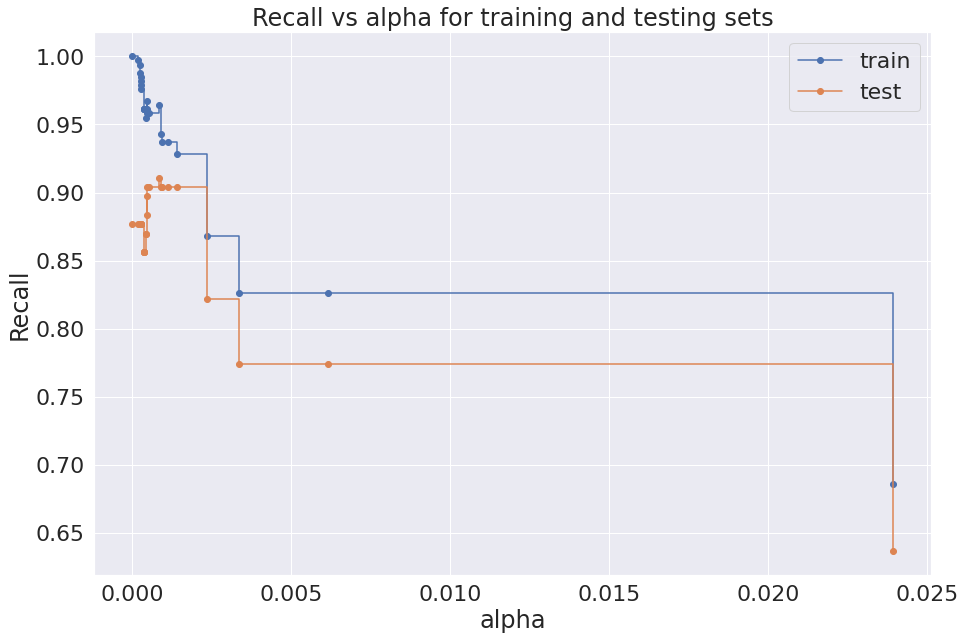

In [98]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_xlabel("alpha")
ax.set_ylabel("Recall")
ax.set_title("Recall vs alpha for training and testing sets")
ax.plot(ccp_alphas, recall_train, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, recall_test, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [99]:
# creating the model where we get highest train and test recall
index_best_model = np.argmax(recall_test)
pruned_model = clfs[index_best_model]
print(pruned_model)

DecisionTreeClassifier(ccp_alpha=0.0008503401360544218, random_state=1)


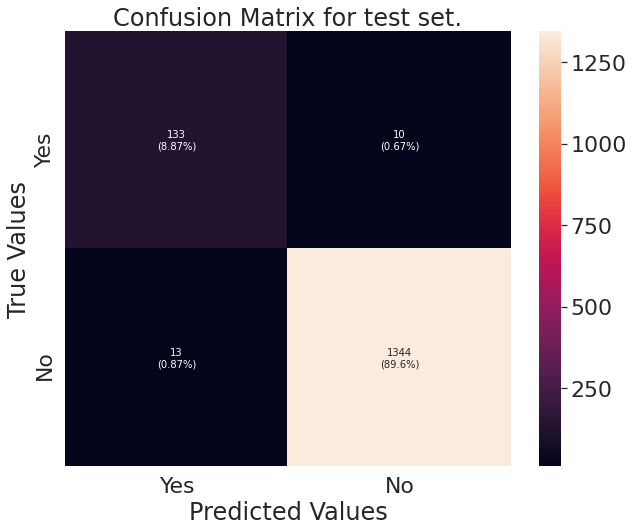

test [[ 133   10]
 [  13 1344]]


In [100]:
ConfusionMatrix(pruned_model.predict(X_test),y_test, set1="test")

In [101]:
pruned_pred_test = pruned_model.predict(X_test)
pruned_pred_train = pruned_model.predict(X_train)

In [102]:
print("Perfomance metrics for Decision Tree (After pruning) on train set")
print("Precision score for train set",precision_score(pruned_pred_train,y_train))
print("Recall score for train set",recall_score(pruned_pred_train,y_train))
print("F1 score for train set",f1_score(pruned_pred_train,y_train))

Perfomance metrics for Decision Tree (After pruning) on train set
Precision score for train set 0.9640718562874252
Recall score for train set 0.9442815249266863
F1 score for train set 0.9540740740740742


In [103]:
print("Perfomance metrics for Decision Tree (After pruning) on test set")
print("Precision score for test set",precision_score(pruned_pred_test,y_test))
print("Recall score for test set",recall_score(pruned_pred_test,y_test))
print("F1 score for test set",f1_score(pruned_pred_test,y_test))

Perfomance metrics for Decision Tree (After pruning) on test set
Precision score for test set 0.910958904109589
Recall score for test set 0.9300699300699301
F1 score for test set 0.9204152249134948


In [104]:
#Visualize the decision tree of the model after pruning

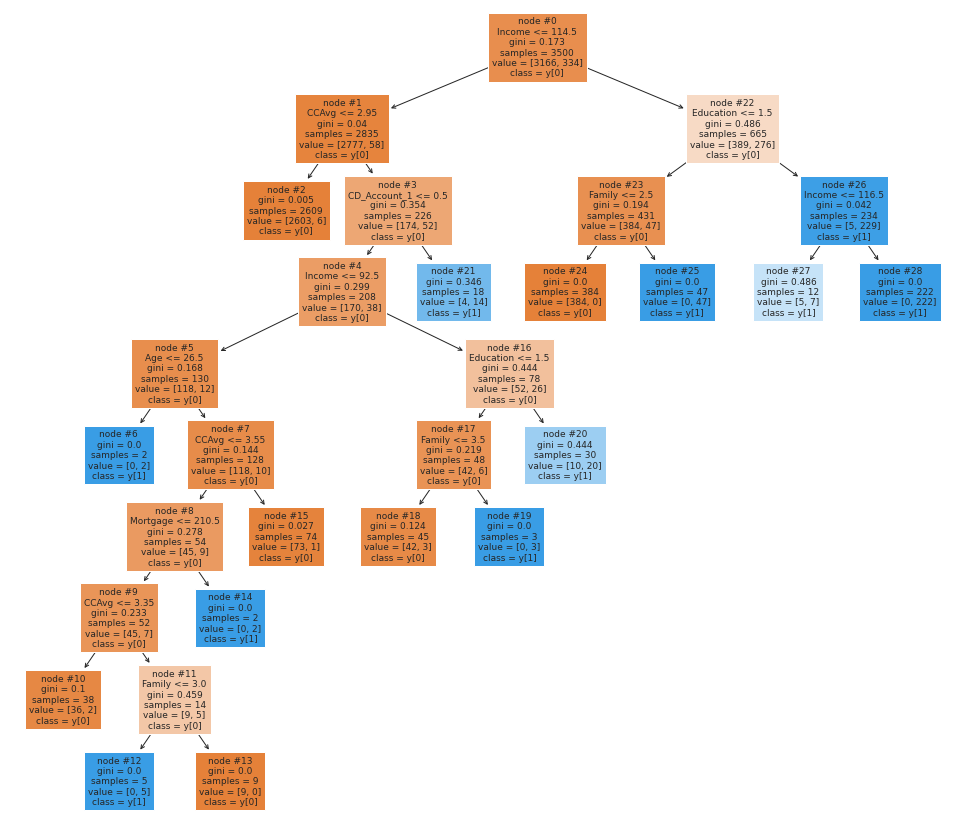

In [105]:
plt.figure(figsize=(17,15))

tree.plot_tree(pruned_model,feature_names=feature_names,filled=True,fontsize=9,node_ids=True,class_names=True)
plt.show()

In [106]:
# Text report showing the rules of a decision tree -

print(tree.export_text(pruned_model,feature_names=feature_names,show_weights=True))

|--- Income <= 114.50
|   |--- CCAvg <= 2.95
|   |   |--- weights: [2603.00, 6.00] class: 0
|   |--- CCAvg >  2.95
|   |   |--- CD_Account_1 <= 0.50
|   |   |   |--- Income <= 92.50
|   |   |   |   |--- Age <= 26.50
|   |   |   |   |   |--- weights: [0.00, 2.00] class: 1
|   |   |   |   |--- Age >  26.50
|   |   |   |   |   |--- CCAvg <= 3.55
|   |   |   |   |   |   |--- Mortgage <= 210.50
|   |   |   |   |   |   |   |--- CCAvg <= 3.35
|   |   |   |   |   |   |   |   |--- weights: [36.00, 2.00] class: 0
|   |   |   |   |   |   |   |--- CCAvg >  3.35
|   |   |   |   |   |   |   |   |--- Family <= 3.00
|   |   |   |   |   |   |   |   |   |--- weights: [0.00, 5.00] class: 1
|   |   |   |   |   |   |   |   |--- Family >  3.00
|   |   |   |   |   |   |   |   |   |--- weights: [9.00, 0.00] class: 0
|   |   |   |   |   |   |--- Mortgage >  210.50
|   |   |   |   |   |   |   |--- weights: [0.00, 2.00] class: 1
|   |   |   |   |   |--- CCAvg >  3.55
|   |   |   |   |   |   |--- weights: [73.00,

In [107]:
# importance of features in the tree building ( The importance of a feature is computed as the 
#(normalized) total reduction of the 'criterion' brought by that feature. It is also known as the Gini importance )

print (pd.DataFrame(pruned_model.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values(by = 'Imp', ascending = False))

                           Imp
Education             0.432374
Income                0.319235
Family                0.171148
CCAvg                 0.044904
CD_Account_1          0.021121
Age                   0.006025
Mortgage              0.005193
Securities_Account_1  0.000000
Online_1              0.000000
CreditCard_1          0.000000


### Comparing all the decision tree models

In [108]:
results = [
    {
        "Model": "Initial DT model with default params",
        "Precision_train":precision_score(pred_train_dt,y_train),
        "Precision_test":precision_score(pred_test_dt,y_test),
        "Recall_train":recall_score(pred_train_dt,y_train),
        "Recall_test":recall_score(pred_test_dt,y_test),
        "F1_train": f1_score(pred_train_dt,y_train),
        "F1_test": f1_score(pred_test_dt,y_test)
    },
    {
        "Model": "DT with the depth restricted",
        "Precision_train":precision_score(pred_train_dt1,y_train),
        "Precision_test":precision_score(pred_test_dt1,y_test),
        "Recall_train":recall_score(pred_train_dt1,y_train),
        "Recall_test":recall_score(pred_test_dt1,y_test),
        "F1_train": f1_score(pred_train_dt1,y_train),
        "F1_test": f1_score(pred_test_dt1,y_test)
    },
    {
        "Model": "DT with hyperparameters tuned with Grid Search",
        "Precision_train": precision_score(pred_train_dt2,y_train),
        "Precision_test":precision_score(pred_test_dt2,y_test),
        "Recall_train":recall_score(pred_train_dt2,y_train),
        "Recall_test":recall_score(pred_test_dt2,y_test),
        "F1_train": f1_score(pred_train_dt2,y_train),
        "F1_test": f1_score(pred_test_dt2,y_test)
    },
    {
        "Model": "Pruned DT",
        "Precision_train": precision_score(pruned_pred_train,y_train),
        "Precision_test":precision_score(pruned_pred_test,y_test),
        "Recall_train":recall_score(pruned_pred_train,y_train),
        "Recall_test":recall_score(pruned_pred_test,y_test),
        "F1_train": f1_score(pruned_pred_train,y_train),
        "F1_test": f1_score(pruned_pred_test,y_test)
    }
]


In [109]:
df_dts = pd.DataFrame(results, index=range(1,5))
df_dts = df_dts[["Model", "Precision_train", "Precision_test", "Recall_train", "Recall_test", "F1_train", "F1_test"]]
df_dts

,Model,Precision_train,Precision_test,Recall_train,Recall_test,F1_train,F1_test
1,Initial DT model with default params,1.000000,0.876712,1.000000,0.934307,1.000000,0.904594
2,DT with the depth restricted,0.868263,0.821918,0.969900,0.975610,0.916272,0.892193
3,DT with hyperparameters tuned with Grid Search,0.928144,0.904110,0.942249,0.942857,0.935143,0.923077
4,Pruned DT,0.964072,0.910959,0.944282,0.930070,0.954074,0.920415


**Remarks:**

1. The decision tree model with the default params seems to be too complex that it overfits. It performs perfect classification on the train data and performance drops on the test set - a possible suggestion of overfitting.
2. To curb overfitting, the second variant of Decision tree has the depth restricted. Such restriction seems to curb overfitting but precision seems low.
3. Performing Grid Search for the best parameters of the decision tree is another decent option. Parameter options are passed into the GridSearch CV which performs a search for the best params. This kind of decision tree led to even a better model than 1 and 2. 
4. Another decision tree variant involves pruning to control the size of the tree. Prunning is parameterized with the attribute *ccp_alpha* on *DecisionTreeClassifier.cost_complexity_pruning_path*. These attribute controls the model complexity.
5. 3 and 4 are great models. We consider 3 as the best model going forward.

## FAILED CASES

- From the performance metrics discussed above, decision tree models performs better than logistic regression model. In this section, we will use the decision tree generated by GridSeaarchCV named *grid_model* and the test set.

In [113]:
# Concat feature columns and the target column 
df_test = pd.concat([X_test, y_test], axis=1)
# Create a Predictions column using the best_model (decision tree variant)
df_test["Predictions"] = grid_model.predict(X_test)
# Filter failed cases - wrong predictions
failed_cases = df_test.loc[df_test["Personal_Loan"] != df_test["Predictions"]]
# First 5 rows of the failed cases dataframe 
failed_cases.head(10)

,Age,Income,Family,CCAvg,Education,Mortgage,Securities_Account_1,CD_Account_1,Online_1,CreditCard_1,Personal_Loan,Predictions
2533,54,111.0,1,1.1,2,0.0,0,0,1,0,1,0
1889,56,111.0,4,0.3,1,252.5,1,1,1,0,1,0
4941,28,112.0,2,1.6,2,0.0,0,0,1,0,1,0
3322,41,104.0,1,4.0,3,0.0,0,1,1,1,0,1
2544,58,90.0,1,3.6,2,0.0,0,0,0,0,1,0
4275,63,102.0,4,3.4,2,0.0,0,0,0,0,0,1
261,42,111.0,2,1.2,3,251.0,0,0,1,0,1,0
2336,34,99.0,2,4.5,3,217.0,0,0,0,0,0,1
3349,55,95.0,2,4.5,3,252.5,0,0,0,0,0,1
4163,54,108.0,4,1.9,2,0.0,0,0,1,0,1,0


**Remarks on Failed Cases:**
- Based on the examples of predictions on class 0, 1 and the failed cases, CD_Account_1 seems to be an important feature when predicting for Personal_Loan. With Certificate of Deposit (CD_Account_1) the customer will likely take Personal_Loan. The bank is likely using the fact that the customer has made a deposit to make the decision to grant the customer the Personal_Loan or not.

### ONE MORE LOOK ON THE PREDICTIONS

In [159]:
# Filter 1 predictions and sample 140 data points
# Samepling 10 data points for both classes so that we avoid possible effect of analysis imbalanced data
one_predictions = df_test.loc[df_test["Personal_Loan"] == 1].sample(n=140, random_state=1)
# First 5 rows of the positive predictions dataframe 
one_predictions.tail(10)

,Age,Income,Family,CCAvg,Education,Mortgage,Securities_Account_1,CD_Account_1,Online_1,CreditCard_1,Personal_Loan,Predictions
4842,49,174.0,3,4.6,2,252.5,0,0,0,0,1,1
243,65,170.0,3,5.2,3,99.0,0,1,1,0,1,1
4309,34,186.5,1,2.9,3,0.0,0,0,1,0,1,1
2951,26,132.0,2,2.4,3,0.0,0,0,0,1,1,1
781,56,158.0,3,3.7,3,0.0,0,0,1,0,1,1
1579,29,122.0,4,3.0,1,0.0,0,0,0,1,1,1
2304,27,170.0,3,4.7,1,0.0,0,0,1,0,1,1
4876,44,142.0,1,1.5,3,0.0,0,0,0,0,1,1
2328,27,130.0,3,4.4,1,192.0,0,0,1,0,1,1
2561,31,180.0,1,2.9,3,144.0,1,0,0,0,1,1


In [154]:
one_predictions.CCAvg.mean()

3.4389285714285713

In [155]:
one_predictions.Income.mean()

141.48214285714286

In [156]:
# Filter 1 predictions
zero_predictions = df_test.loc[df_test["Personal_Loan"] == 0].sample(n=140, random_state=1)
# First 5 rows of the negative predictions dataframe 
zero_predictions.tail(5)

,Age,Income,Family,CCAvg,Education,Mortgage,Securities_Account_1,CD_Account_1,Online_1,CreditCard_1,Personal_Loan,Predictions
633,61,18.0,1,1.5,3,0.0,0,0,1,1,0,0
1156,49,13.0,4,0.2,1,87.0,0,0,0,0,0,0
3483,60,186.5,1,4.7,1,0.0,0,0,1,0,0,0
14,67,112.0,1,2.0,1,0.0,1,0,0,0,0,0
4207,37,51.0,3,2.1,1,0.0,0,0,1,1,0,0


In [157]:
zero_predictions.CCAvg.mean()

1.5947857142857143

In [158]:
zero_predictions.Income.mean()

68.23928571428571

### TAKE AWAYS

- Decision Tree models performed better than Logistic regression in all respect. This could be attributed to the fact that Decision Trees are non-linear classifies - they do not require data to be linearly separable. On the other hand Linear Regression model is best used when dataset divides into two separable parts. The dataset we have is highly unlikely that it is linearly separable and for that reason Decision Trees perfomed better when compared with Logistic Regression.
- On analysis of feature importance: Education, Income, Family and CCAvg featured as most important features in that order.
- AllLife Bank should focus campaign on the customer segment that are likely to take personal loan. Such segment can be determined by analysing decisions made by the customers as per the 4 most important features. The analysis is done below:

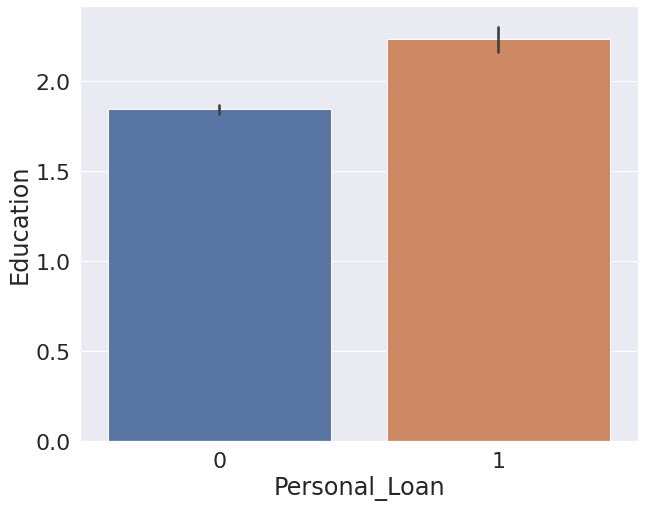

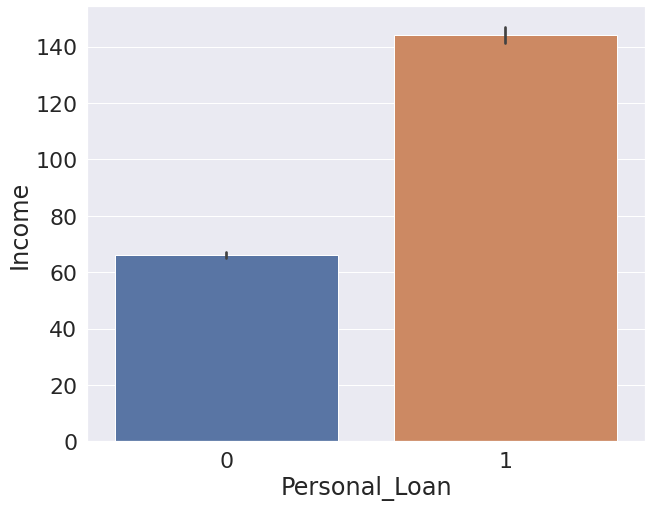

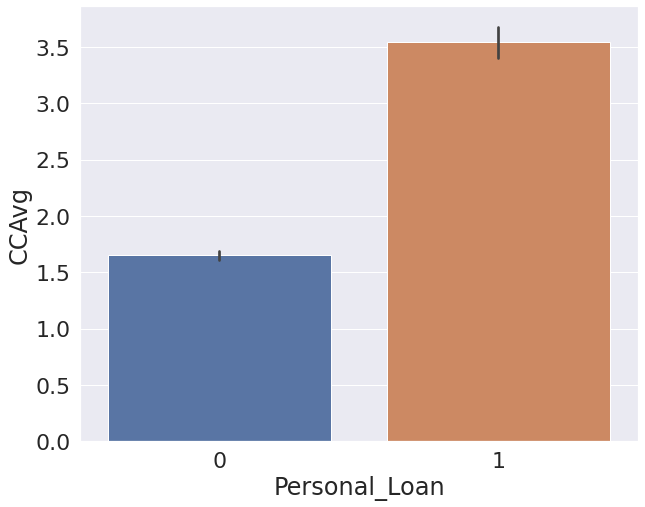

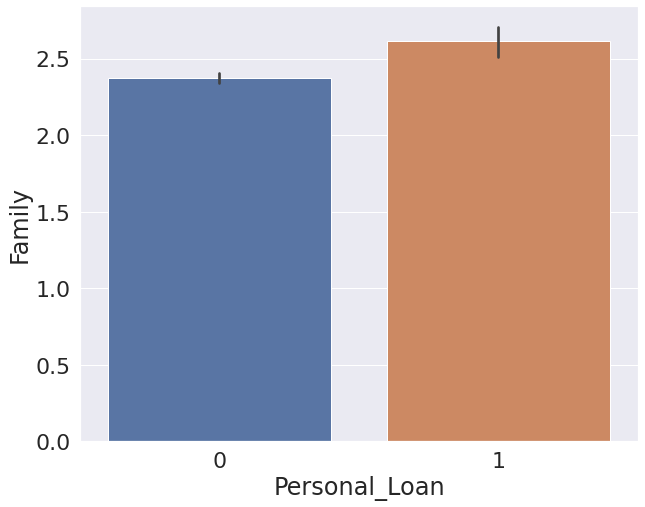

In [166]:
for col in ["Education", "Income" ,"CCAvg", "Family"]:
    plt.figure(figsize=(10,8))
    sns.barplot(x=df["Personal_Loan"],y=df[col])
    plt.show()

**Remark:**
- AllLife Bank should focus the campaign on people with higher education, higher income, high expernditure on credit cards, and bigger families.